# Import libraries

In [252]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"   
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from keras import initializers
from keras import metrics
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# GSPC data

In [214]:
GSPC = pd.read_csv('GSPC_index_close_test123.csv')
GSPC['Date']=pd.to_datetime(GSPC['Date'])
GSPC.set_index('Date', inplace=True)
GSPC=GSPC.T
GSPC_noisy = pd.DataFrame(np.repeat(GSPC.values,100,axis=0), columns=GSPC.columns)

# plt.figure(figsize=(15,6),dpi=200)
# plt.plot(GSPC_noisy.iloc[0],label='Close price')
# plt.title('Orignal close data')
# plt.legend()
# plt.show()
GSPC_noisy=GSPC_noisy.iloc[:,1:]

In [215]:
GSPC_T=GSPC.T
GSPC_pure=pd.DataFrame(columns=GSPC.columns)
for window in range(2,52):#SMA and EMA of the day, which using today's price and is the next day's SMA and EMA
    rolling_mean = GSPC_T['Close'].rolling(window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  GSPC_T['Close'].ewm(span=window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
GSPC_pure=GSPC_pure.iloc[:,1:]#.shift(periods=1, freq=None, axis=1)
GSPC_pure

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
0,2264.290039,2269.875,2272.98999,2272.939941,2268.899902,2272.109985,2272.880005,2272.539917,2271.264893,2269.889893,...,2572.944946,2546.049927,2526.559937,2487.189941,2442.02002,2383.860107,2409.400024,2478.265015,2487.285034,2496.295044
1,2264.290039,2265.860026,2272.243327,2271.626628,2271.593262,2271.039958,2271.553304,2273.466634,2270.989909,2271.473226,...,2598.809977,2564.016602,2533.019938,2506.846598,2463.666667,2411.713379,2411.806722,2435.876709,2480.756673,2493.806722
2,2264.290039,2265.860026,2268.640015,2271.407471,2270.944946,2272.524963,2270.889954,2272.324951,2272.072449,2271.214905,...,2611.875,2585.647461,2549.752441,2516.619934,2484.289978,2435.525024,2425.710022,2431.062561,2448.342529,2487.280029
3,2264.290039,2265.860026,2268.640015,2268.691992,2270.905957,2271.819971,2272.107959,2271.639941,2271.437939,2272.035937,...,2616.856006,2598.731982,2569.909961,2533.285937,2496.619971,2457.652002,2441.96001,2438.334033,2441.998047,2460.044043
4,2264.290039,2265.860026,2268.640015,2268.691992,2268.726644,2271.641642,2271.589966,2272.529948,2271.014933,2271.513265,...,2620.333333,2605.073324,2583.436646,2552.828288,2513.841634,2472.366659,2459.32666,2449.771688,2446.235026,2452.806722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2264.427485,2266.016965,2268.935088,2268.92744,2268.922348,2269.957027,2270.026755,2270.630799,2270.301319,2270.478373,...,2716.633637,2709.530565,2701.090123,2691.353864,2679.906625,2666.206353,2657.935253,2650.889204,2644.007987,2638.293075
96,2264.424622,2266.013727,2268.928967,2268.92266,2268.918461,2269.951171,2270.02154,2270.624275,2270.296787,2270.473627,...,2717.947105,2710.935383,2702.609856,2693.010266,2681.729036,2668.233977,2660.048915,2653.060391,2646.230987,2640.541971
97,2264.421875,2266.010619,2268.923095,2268.91807,2268.914725,2269.945548,2270.016528,2270.618008,2270.292425,2270.469058,...,2719.229206,2712.306434,2704.092575,2694.625669,2683.505447,2670.209233,2662.108862,2655.17771,2648.400202,2642.738197
98,2264.419238,2266.007635,2268.917456,2268.913659,2268.911131,2269.940144,2270.011708,2270.611983,2270.288223,2270.464657,...,2720.480251,2713.644159,2705.538897,2696.200898,2685.236945,2672.13354,2664.116536,2657.242557,2650.516966,2644.882972


# Bit data

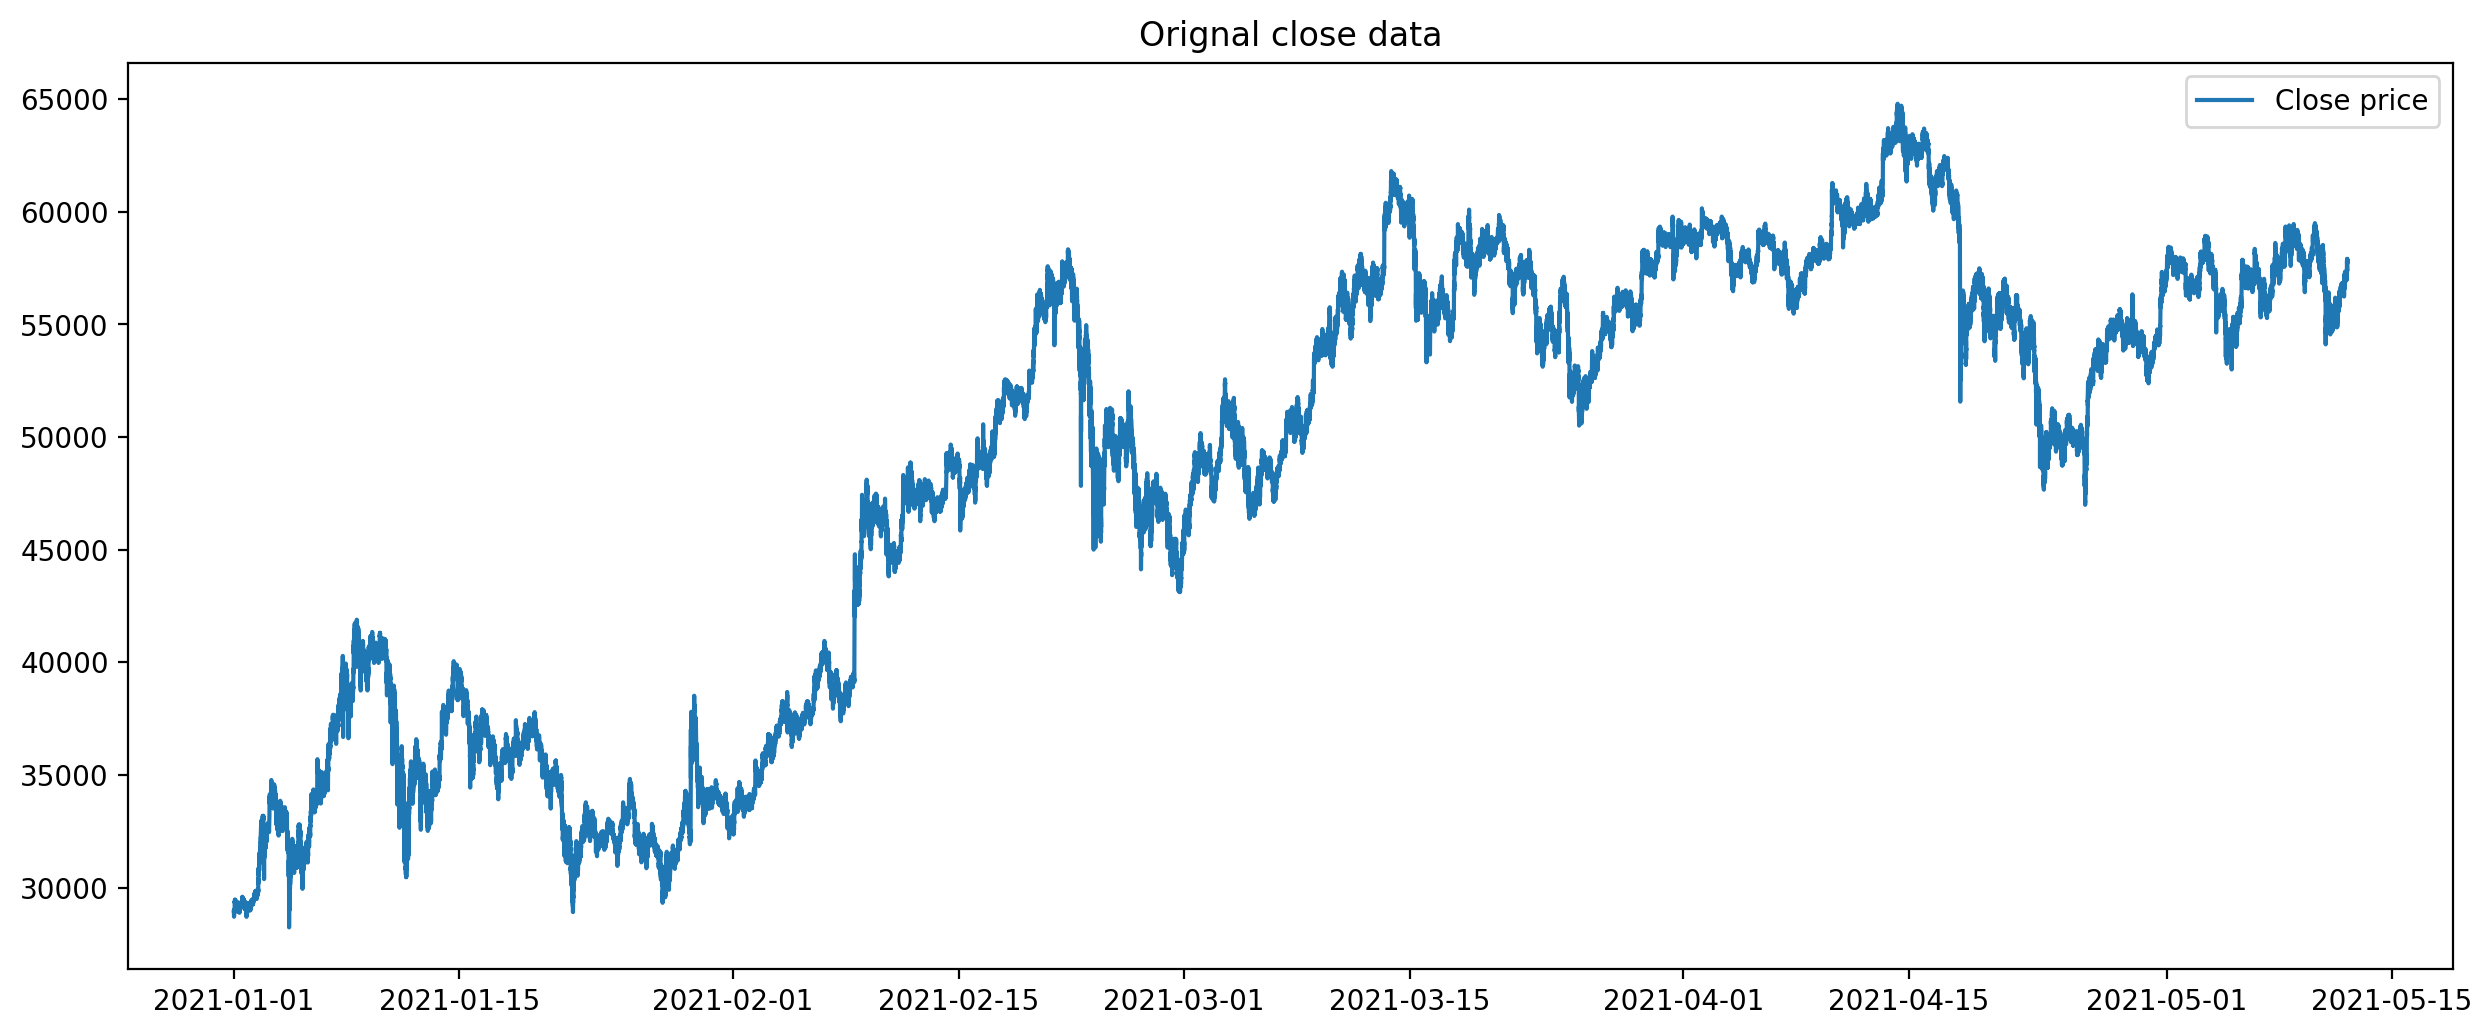

In [216]:
bit = pd.read_csv('bit_c_1m.csv')
bit=bit.iloc[:,1:]
bit['Open Time']=pd.to_datetime(bit['Open Time'])
bit.set_index('Open Time', inplace=True)
bit=bit.T
bit_noisy = pd.DataFrame(np.repeat(bit.values,100,axis=0), columns=bit.columns)

plt.figure(figsize=(15,6),dpi=200)
plt.plot(bit_noisy.iloc[0],label='Close price')
plt.title('Orignal close data')
plt.legend()
plt.show()
bit_noisy=bit_noisy.iloc[:,1:]

In [217]:
bit_T=bit.T
bit_pure=pd.DataFrame(columns=bit.columns)
for window in range(2,52):#SMA and EMA of the day, which using today's price and is the next day's SMA and EMA
    rolling_mean = bit_T['Close'].rolling(window,min_periods=1).mean()
    bit_pure=pd.concat([bit_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  bit_T['Close'].ewm(span=window,min_periods=1).mean()
    bit_pure=pd.concat([bit_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
bit_pure=bit_pure.iloc[:,1:]#.shift(periods=1, freq=None, axis=1)
bit_pure

Open Time,2021-01-01 00:01:00,2021-01-01 00:02:00,2021-01-01 00:03:00,2021-01-01 00:04:00,2021-01-01 00:05:00,2021-01-01 00:06:00,2021-01-01 00:07:00,2021-01-01 00:08:00,2021-01-01 00:09:00,2021-01-01 00:10:00,...,2021-05-12 05:30:00,2021-05-12 05:31:00,2021-05-12 05:32:00,2021-05-12 05:33:00,2021-05-12 05:34:00,2021-05-12 05:35:00,2021-05-12 05:36:00,2021-05-12 05:37:00,2021-05-12 05:38:00,2021-05-12 05:39:00
0,28985.785,28999.605,28985.995,28979.17,28956.38,28940.49,28939.355,28917.42,28879.47,28853.81,...,57674.69,57631.11,57581.94,57549.825,57524.385,57503.195,57483.28,57475.745,57460.45,57450.545
1,28985.785,28986.956667,28993.966667,28982.546667,28965.15,28952.21,28938.606667,28926.236667,28897.926667,28869.206667,...,57674.386667,57647.02,57611.473333,57563.776667,57540.323333,57511.28,57495.96,57478.853333,57467.463333,57457.03
2,28985.785,28986.956667,28985.89,28989.3875,28971.1875,28959.83,28947.8675,28928.955,28909.4125,28885.615,...,57676.465,57653.71,57628.315,57590.4675,57553.1625,57526.51,57503.8325,57489.47,57471.865,57463.145
3,28985.785,28986.956667,28985.89,28983.842,28978.932,28965.724,28954.832,28938.294,28914.952,28897.266,...,57673.732,57659.508,57637.408,57608.142,57576.638,57539.544,57517.506,57497.066,57481.756,57467.53
4,28985.785,28986.956667,28985.89,28983.842,28976.053333,28973.088333,28960.576667,28945.693333,28925.068333,28903.906667,...,57678.908333,57660.056667,57644.956667,57619.081667,57593.671667,57561.376667,57529.868333,57509.588333,57489.371667,57476.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,28986.298298,28987.341738,28986.103544,28983.8312,28975.192971,28970.12723,28965.032085,28956.516786,28944.787223,28934.075622,...,57684.407634,57680.543982,57676.02965,57669.838831,57663.650546,57656.20969,57648.929703,57641.474299,57633.533703,57625.894382
96,28986.287604,28987.333859,28986.099348,28983.831773,28975.211632,28970.155588,28965.071157,28956.578807,28944.884946,28934.205925,...,57681.226855,57677.571882,57673.270989,57667.319111,57661.359964,57654.164455,57647.116518,57639.887273,57632.173506,57624.745608
97,28986.277347,28987.326297,28986.095313,28983.832308,28975.229503,28970.182763,28965.108615,28956.638265,28944.978626,28934.330854,...,57678.016776,57674.563305,57670.468773,57664.748022,57659.010901,57652.053265,57645.230735,57638.221505,57630.728645,57623.507099
98,28986.2675,28987.319031,28986.091431,28983.83281,28975.246633,28970.208827,28965.144555,28956.695315,28945.068505,28934.450733,...,57674.781748,57671.522856,57667.627842,57662.130672,57656.608685,57649.881677,57643.278082,57636.482863,57629.205104,57622.184904


# GSPC

## Fit models(ltsm/cnn)

## MinMaxScaler(GSPC)

In [218]:
mm_t_g = MinMaxScaler()
gnoise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
gprue_mm=mm_t_g.transform(GSPC_pure.T).T
print(gprue_mm.shape)
print(gnoise_mm.shape)

(100, 501)
(100, 501)


In [219]:
gtrain_prue_mm=np.reshape(gprue_mm,(len(gprue_mm), len(gprue_mm[0]), 1))
gtrain_mm=np.reshape(gnoise_mm, (len(gnoise_mm), len(gnoise_mm[0]), 1))

# convert list to numpy array
X_train_mmg = np.asarray(gtrain_mm)
Y_train_mmg = np.asarray(gtrain_prue_mm)
X_train_mmg, X_val_mmg, Y_train_mmg, Y_val_mmg = train_test_split(X_train_mmg, Y_train_mmg, test_size=0.2,random_state=0)

In [220]:
GSPC_test = pd.read_csv('GSPC_index_close_test123.csv')
GSPC_test['Date']=pd.to_datetime(GSPC_test['Date'])
GSPC_test.set_index('Date', inplace=True)
GSPC_test=GSPC_test[1:]

## LSTM

In [13]:
def set_model_LSTM():
    model = Sequential()
    #model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(LSTM(8, input_shape=(None, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    #model.add(AveragePooling1D(2, padding='same'))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    model.add(LSTM(8, activation='tanh',return_sequences = True))
    #model.add(UpSampling1D(2))
    #model.add(Dense(1,activation='tanh'))#
    model.add(Conv1D(1,kernel_size=2,activation='relu', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, None, 4)           208       
                                                                 
 lstm_2 (LSTM)               (None, None, 4)           144       
                                                                 
 lstm_3 (LSTM)               (None, None, 8)           416       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 1)           17        
                                                                 
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [14]:
callback = EarlyStopping(monitor='loss', patience=10)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=800, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/800
3/3 [==============================] - 7s 896ms/step - loss: 0.3136 - mae: 0.4874 - val_loss: 0.3019 - val_mae: 0.4751
Epoch 2/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2920 - mae: 0.4651 - val_loss: 0.2678 - val_mae: 0.4424
Epoch 3/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2563 - mae: 0.4304 - val_loss: 0.2280 - val_mae: 0.4020
Epoch 4/800
3/3 [==============================] - 1s 390ms/step - loss: 0.2154 - mae: 0.3880 - val_loss: 0.1842 - val_mae: 0.3534
Epoch 5/800
3/3 [==============================] - 1s 430ms/step - loss: 0.1713 - mae: 0.3387 - val_loss: 0.1393 - val_mae: 0.3028
Epoch 6/800
3/3 [==============================] - 1s 396ms/step - loss: 0.1272 - mae: 0.2888 - val_loss: 0.0975 - val_mae: 0.2533
Epoch 7/800
3/3 [==============================] - 1s 400ms/step - loss: 0.0875 - mae: 0.2425 - val_loss: 0.0643 - val_mae: 0.2164
Epoch 8/800
3/3 [==============================] - 1s 390ms/step - loss: 0.0581 - m

In [49]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [19]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

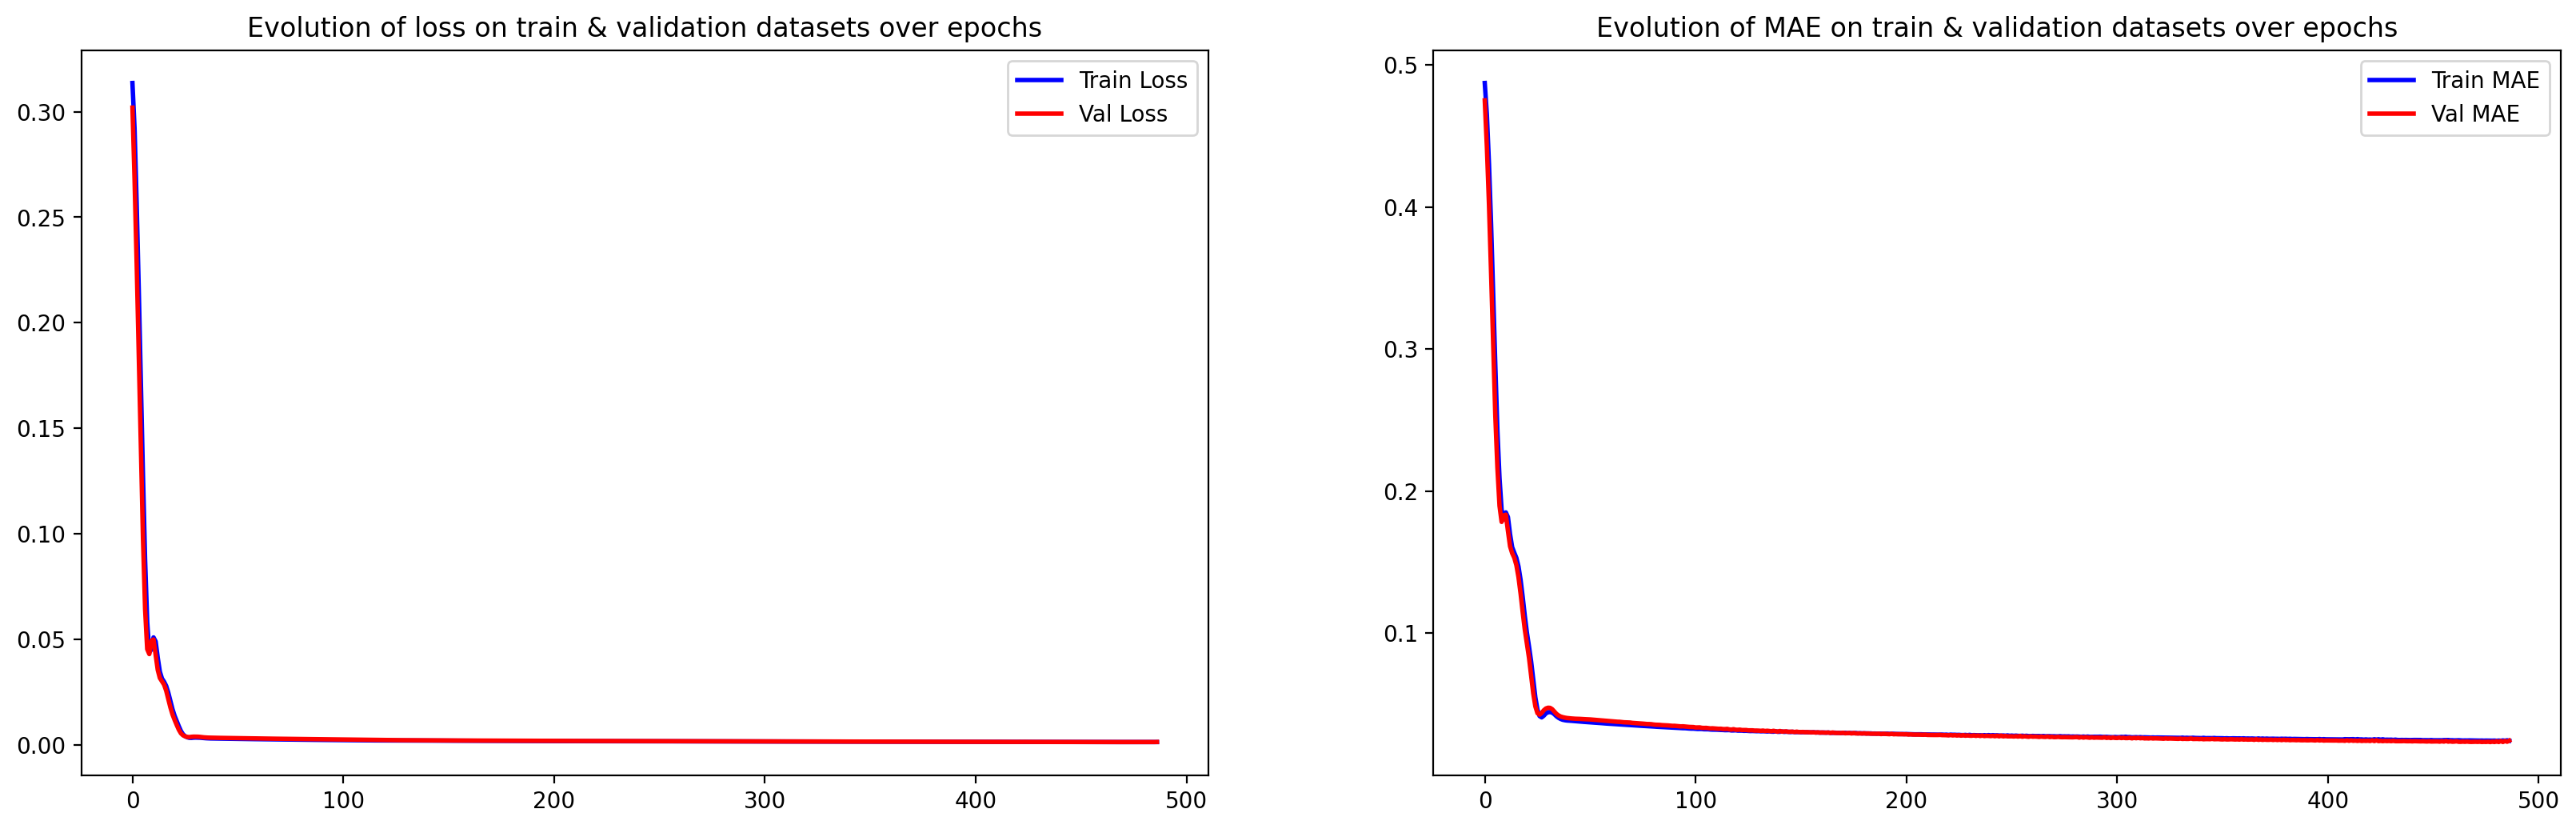

In [15]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mae = history_LSTM.history['mae']
epoch_val_mae = history_LSTM.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 1s 1s/step


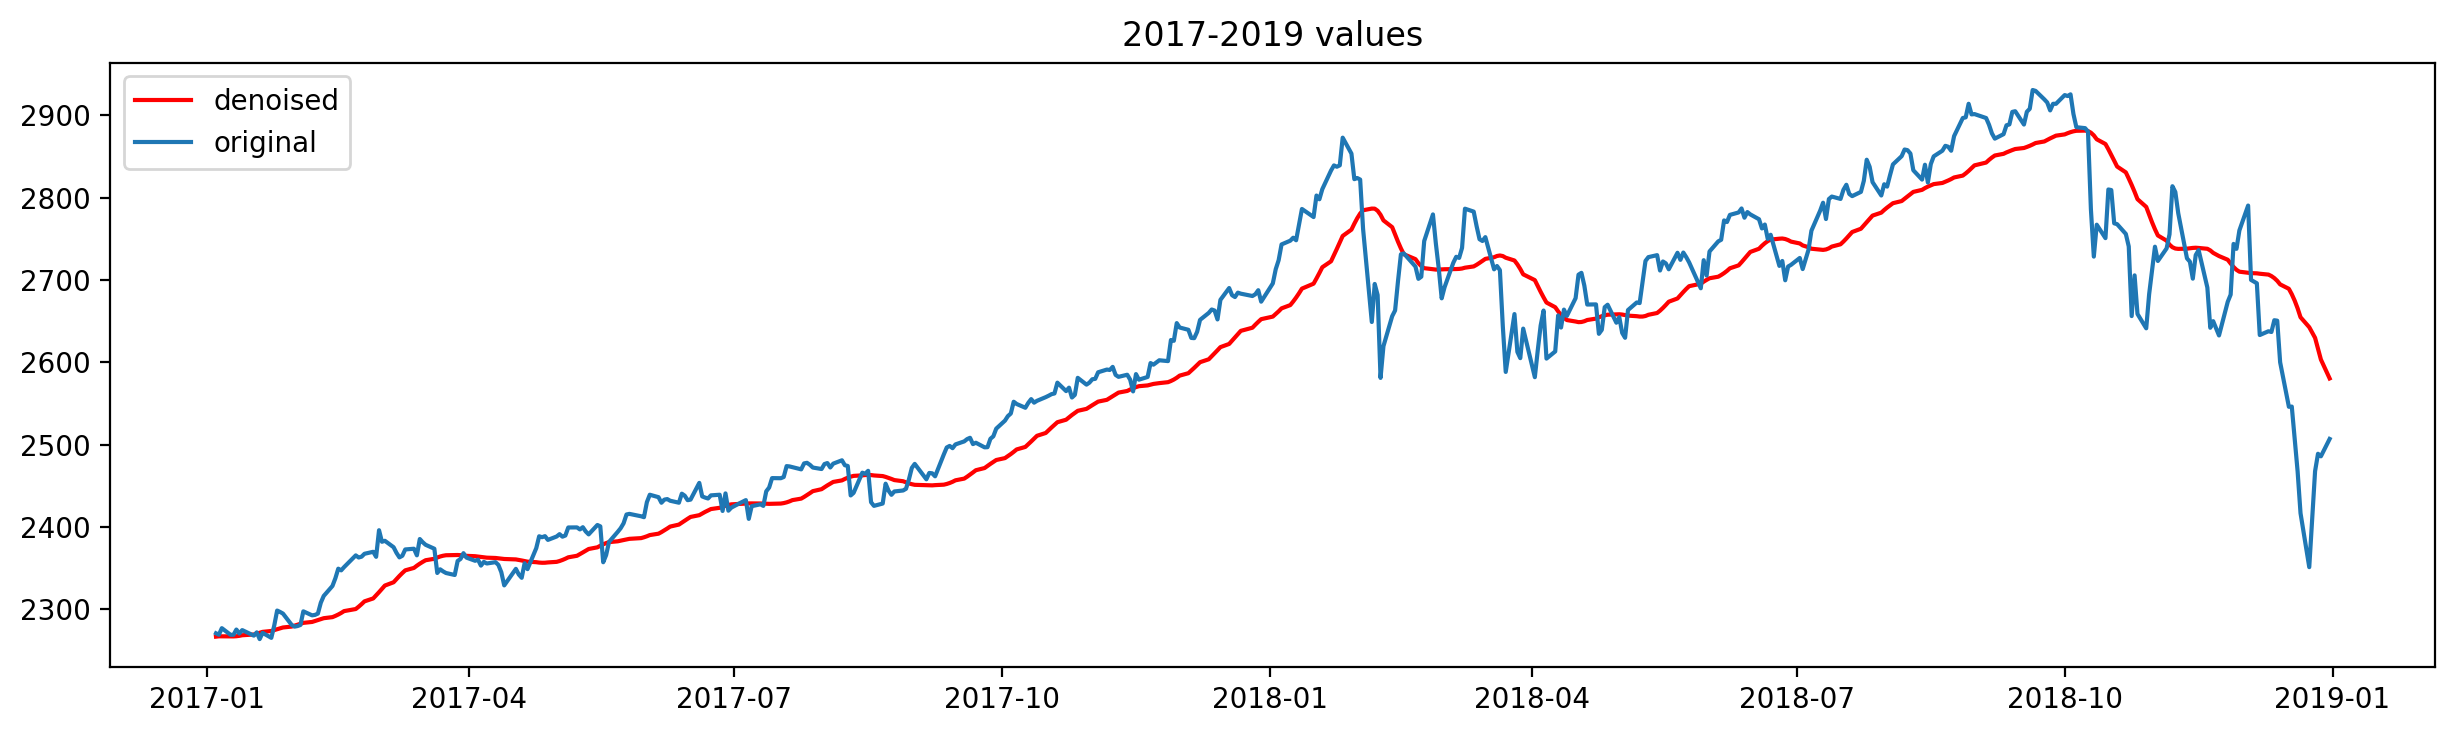

In [16]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=16)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((len(GSPC_test),1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 values')
plt.legend(['denoised', 'original'], loc='upper left')

## CNN

In [316]:
def set_model_encoding_mmg():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=2,activation='tanh',padding='same'))
    model.add(Conv1D(32, kernel_size=2, activation='tanh', padding='same'))
    model.add(Conv1D(64, kernel_size=2,activation='tanh',padding='same'))
    model.add(Conv1D(1,kernel_size=2,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mmg = set_model_encoding_mmg()
modelen_mmg.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_90 (Conv1D)          (None, None, 64)          192       
                                                                 
 conv1d_91 (Conv1D)          (None, None, 32)          4128      
                                                                 
 conv1d_92 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_93 (Conv1D)          (None, None, 64)          4160      
                                                                 
 conv1d_94 (Conv1D)          (None, None, 1)           129       
                                                                 
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________


In [317]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mmg = modelen_mmg.fit(X_train_mmg, Y_train_mmg, validation_data = (X_val_mmg, Y_val_mmg), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
3/3 [==============================] - 1s 80ms/step - loss: 0.0704 - mae: 0.2334 - val_loss: 0.0588 - val_mae: 0.2038
Epoch 2/400
3/3 [==============================] - 0s 28ms/step - loss: 0.0580 - mae: 0.1995 - val_loss: 0.0538 - val_mae: 0.1872
Epoch 3/400
3/3 [==============================] - 0s 30ms/step - loss: 0.0531 - mae: 0.1862 - val_loss: 0.0465 - val_mae: 0.1757
Epoch 4/400
3/3 [==============================] - 0s 38ms/step - loss: 0.0450 - mae: 0.1745 - val_loss: 0.0380 - val_mae: 0.1646
Epoch 5/400
3/3 [==============================] - 0s 37ms/step - loss: 0.0365 - mae: 0.1631 - val_loss: 0.0292 - val_mae: 0.1476
Epoch 6/400
3/3 [==============================] - 0s 35ms/step - loss: 0.0268 - mae: 0.1415 - val_loss: 0.0179 - val_mae: 0.1145
Epoch 7/400
3/3 [==============================] - 0s 34ms/step - loss: 0.0162 - mae: 0.1090 - val_loss: 0.0101 - val_mae: 0.0860
Epoch 8/400
3/3 [==============================] - 0s 34ms/step - loss: 0.0095 - mae: 0.08

In [313]:
modelen_mm.save_weights('model_weights_mmg.h5', overwrite=True)  

In [229]:
modelen_mm.load_weights('model_weights_mmg.h5') 

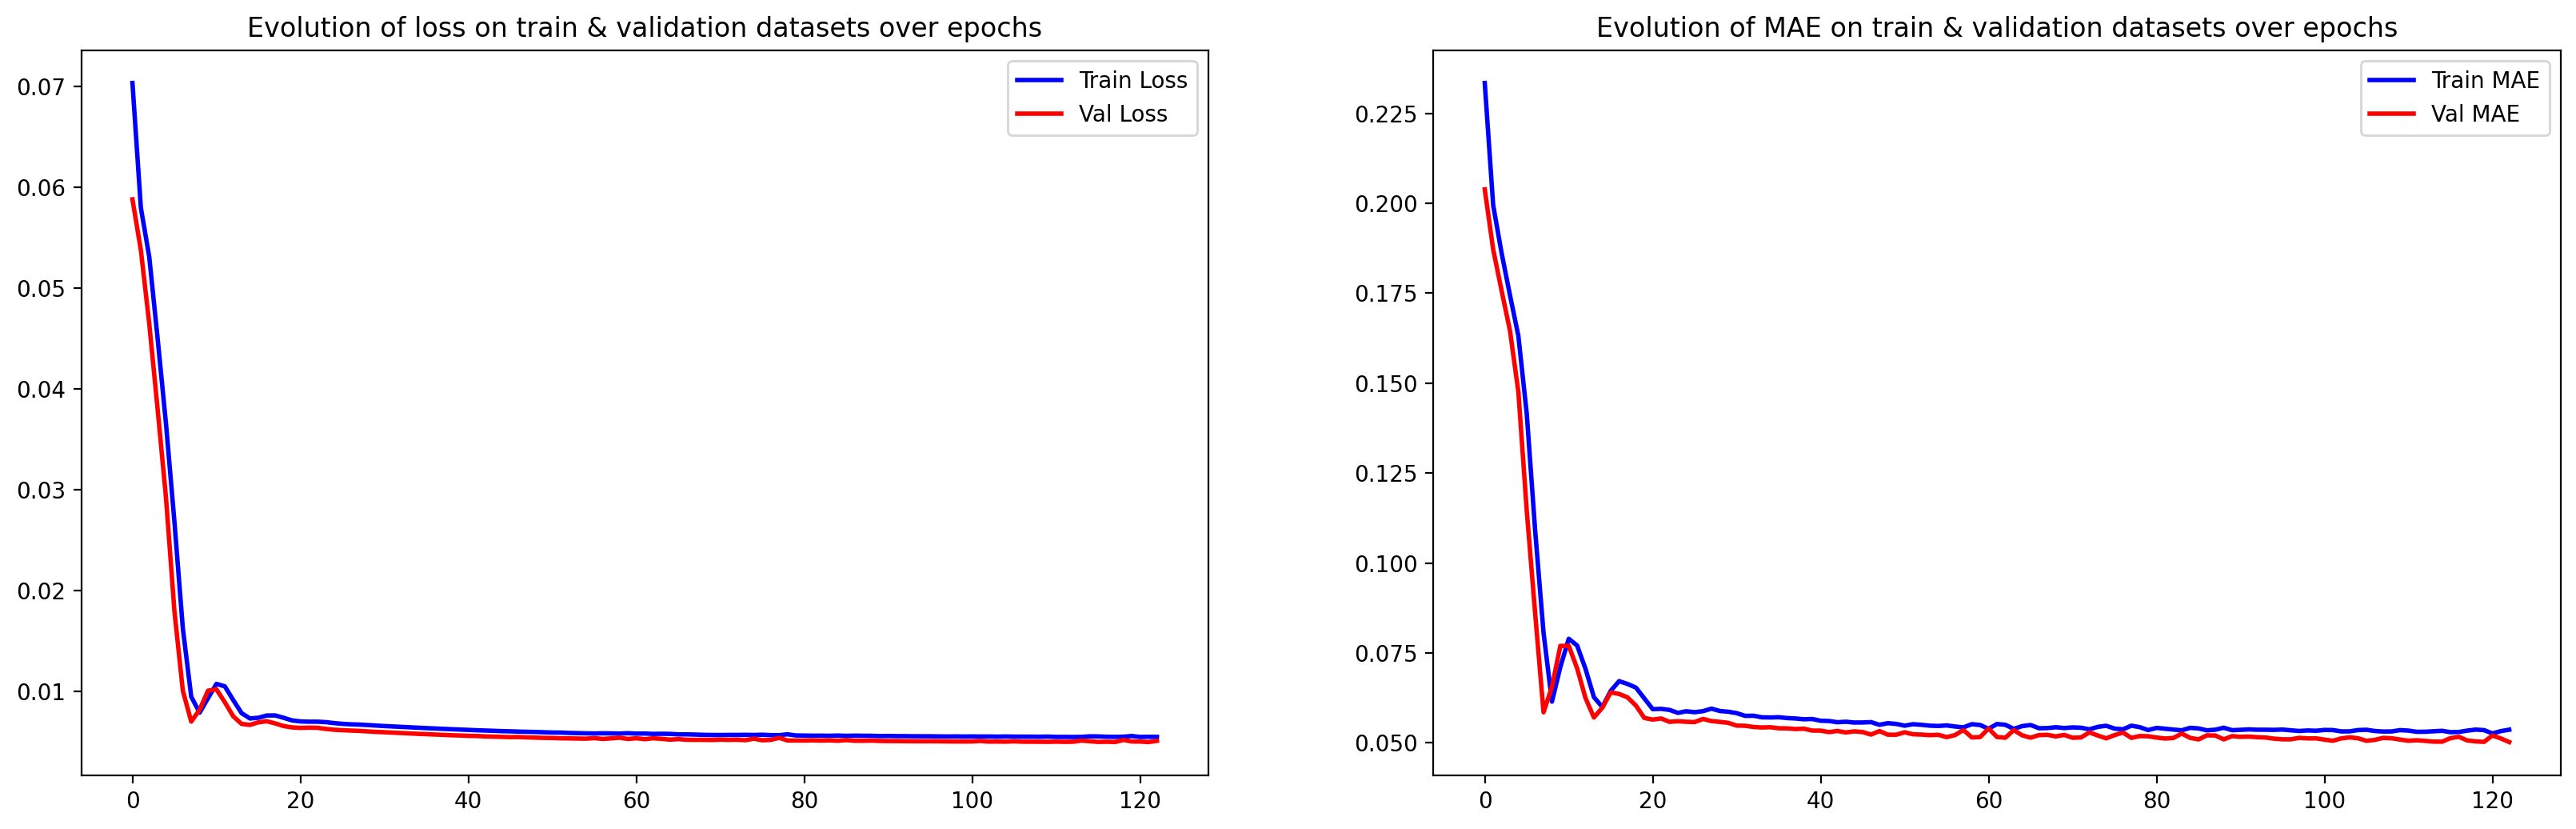

In [318]:
# Check how loss & mae went down
epoch_loss = history_mmg.history['loss']
epoch_val_loss = history_mmg.history['val_loss']
epoch_mae = history_mmg.history['mae']
epoch_val_mae = history_mmg.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 0s 71ms/step


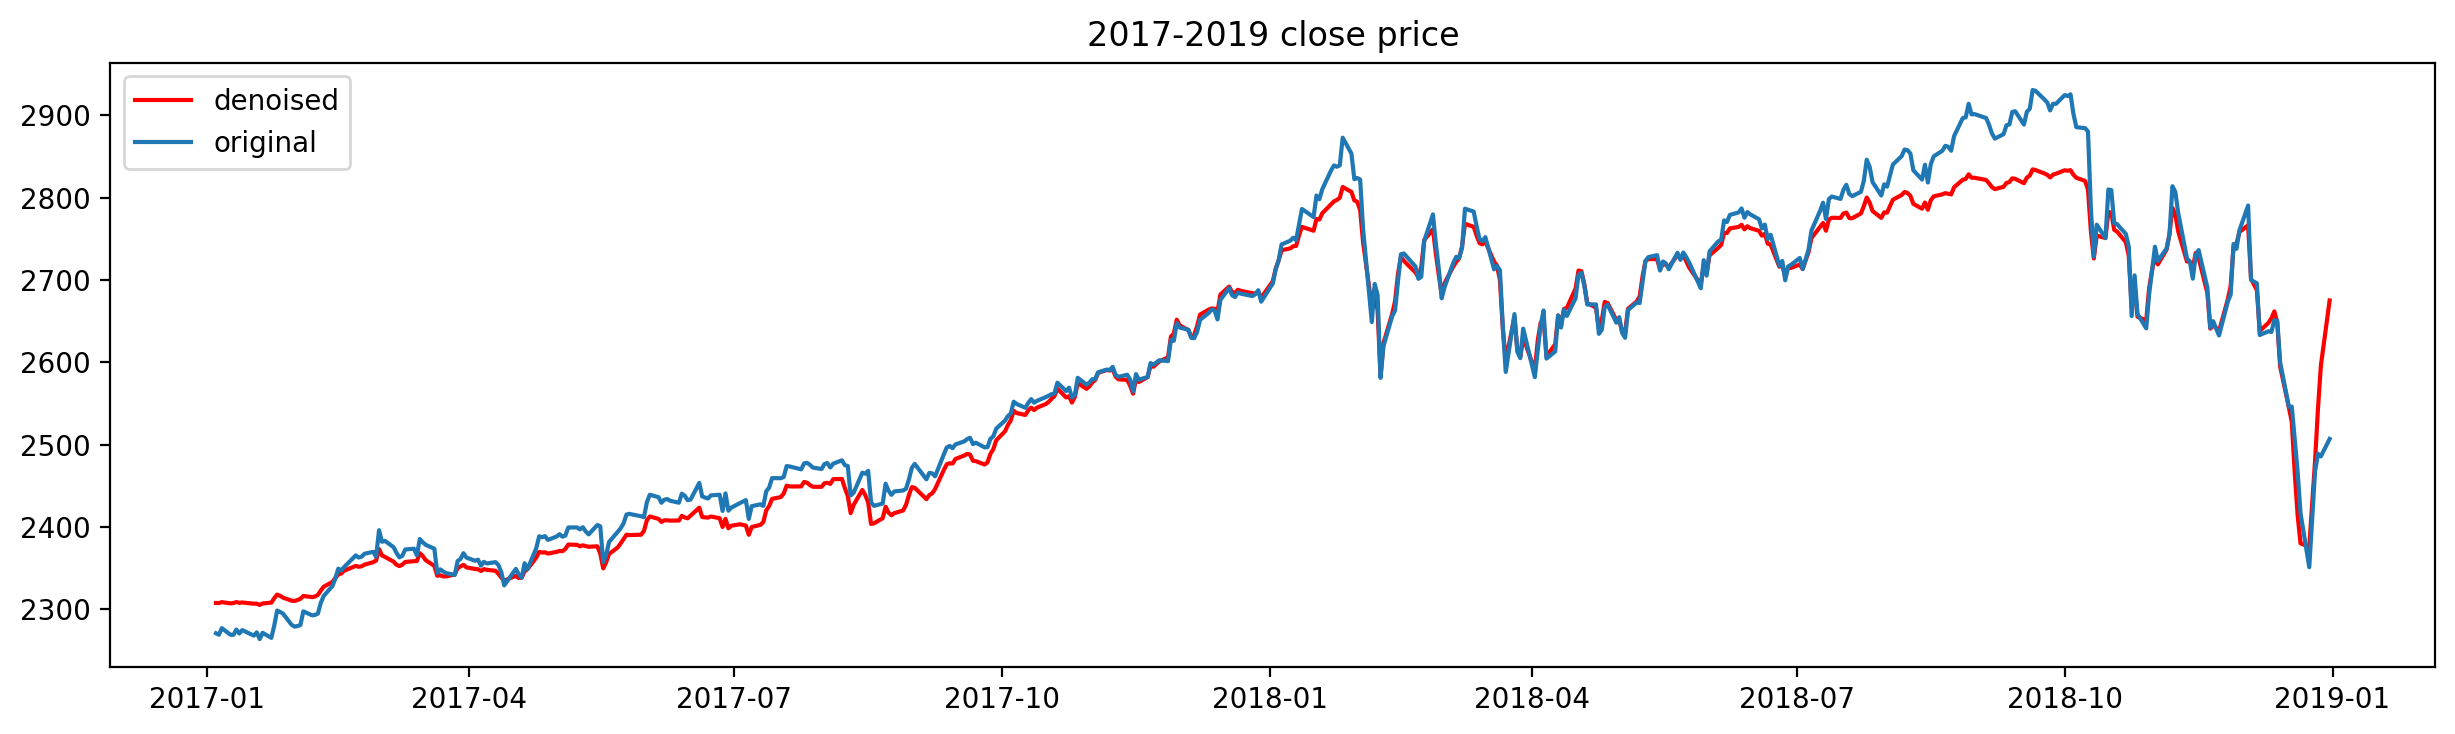

In [319]:
mm_tg = MinMaxScaler()
noise_mm_Tg=mm_tg.fit_transform(GSPC_test)
Y_test_mm_cnng = modelen_mmg.predict(noise_mm_Tg.T)
Y_test_mm_cnng=Y_test_mm_cnng.reshape((len(GSPC_test),1))
pure_mm_cnng = mm_tg.inverse_transform(Y_test_mm_cnng)
pure_mm_cnng=pd.DataFrame(pure_mm_cnng,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnng,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 close price')
plt.legend(['denoised', 'original'], loc='upper left')

## Models' prediction

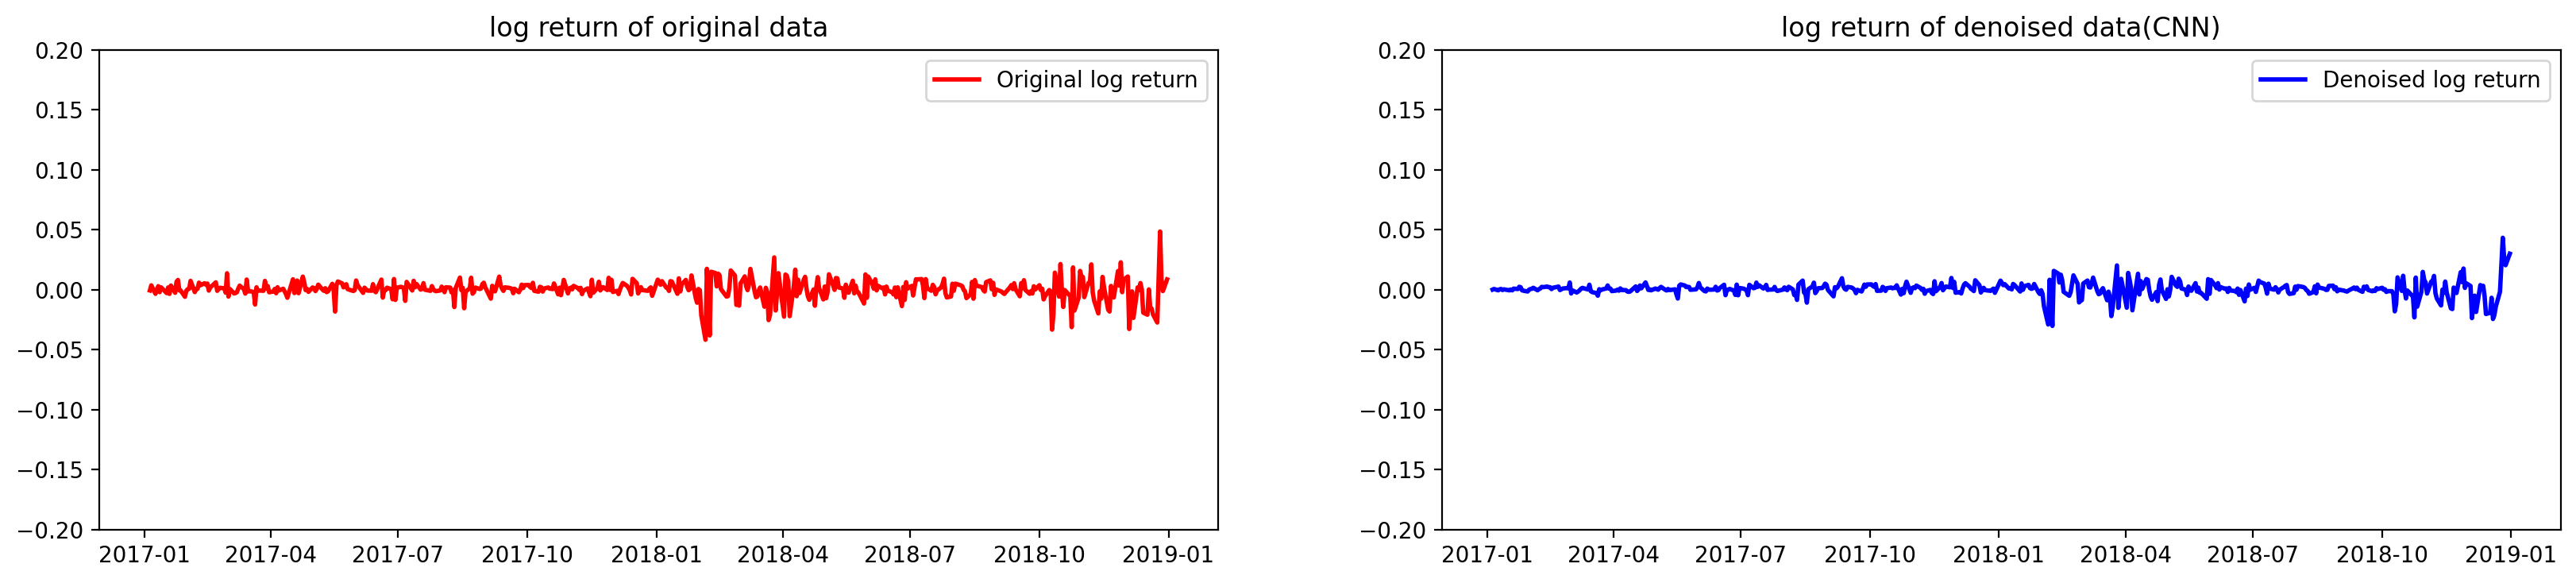

In [320]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
#pure_mm_lstm['log_ret'] = np.log(pure_mm_lstm.iloc[:,0]).diff()
pure_mm_cnng['log_ret'] = np.log(pure_mm_cnng.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnng['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

# plt.subplot(1,3,3)
# plt.plot(pure_mm_lstm['log_ret'], 'y-', linewidth=2, label='Denoised log return')
# plt.ylim(-0.2,0.2)
# plt.title('log return of denoised data(LSTM)')
# plt.legend(loc='best')

plt.show()

## SVM

In [233]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [309]:
def svmf1(dataset,dataset2,long_predict=10):
    f1=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset['log_ret'].max()
    else:
        max_t=dataset2['log_ret'].max()
    for n in np.arange(0.0, (0.7*max_t), (0.7*max_t)/100):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=2,error_score=1).mean())
        
        # for dataset2
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X2=pd.DataFrame()
        Y2=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X2=pd.concat([X2, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y2=pd.concat([Y2, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X2=np.array(X2)
        Y2=np.array(Y2[0])
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f12=np.append(f12,cross_val_score(svc_rbf , X_train2, Y_train2, scoring='f1_micro',cv=2,error_score=1).mean())
    return f1,f12

In [321]:
original_svmg,denoised_svmg=svmf1(GSPC_test_n,pure_mm_cnng)

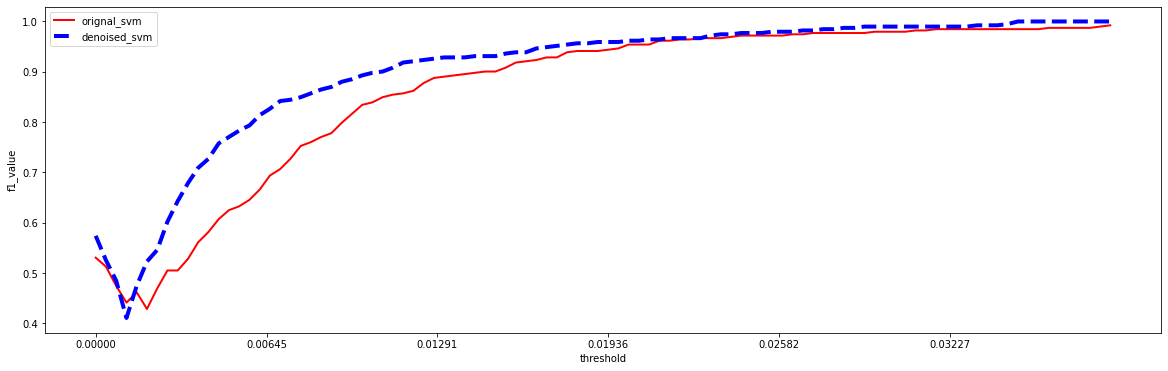

In [322]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0,(max_t-0.2*max_t), (max_t-0.2*max_t)/100),original_svmg,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(max_t-0.2*max_t), (max_t-0.2*max_t)/100),denoised_svmg,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnng['log_ret'].max():
    max_t=GSPC_test_n['log_ret'].max()
else:
    max_t=pure_mm_cnng['log_ret'].max()
plt.xticks(np.arange(0.0,(max_t-0.2*max_t), (max_t-0.2*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## LSTM

In [435]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_lstm)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.007, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.007, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.007, 0.001))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Strategies 

## Bollinger band

In [323]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [324]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [325]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)
#GSPC_test_signal
# GSPC_test_signal[~np.isnan(GSPC_test_signal['signal'])]
# GSPC_test_signal[GSPC_test_signal['signal']==1.0]

pure_mm_cnng_signal=buy_signal_function(pure_mm_cnng)
#pure_mm_cnn_signal
#pure_mm_cnn_signal[pure_mm_cnn_signal['signal']==1.0]

#pure_mm_lstm_signal=buy_signal_function(pure_mm_lstm,GSPC_test_n,pure_mm_cnn,pure_mm_lstm)
#pure_mm_lstm_signal
#pure_mm_lstm_signal[pure_mm_lstm_signal['signal']==1.0]

In [326]:
# Compute sides
# print('GSPC_test_side:\n',GSPC_test_signal.side.value_counts(),'\n')
# print('pure_mm_cnn_side:\n',pure_mm_cnn_signal.side.value_counts(),'\n')
# print('pure_mm_lstm_side:\n',pure_mm_lstm_signal.side.value_counts(),'\n')

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnng_signal:\n',pure_mm_cnng_signal.signal.value_counts(),'\n')
#print('pure_mm_lstm_signal:\n',pure_mm_lstm_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    17
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnng_signal:
 -1.0    14
 1.0    13
Name: signal, dtype: int64 



In [327]:
# GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index

print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnng_signal.signal == 1.0])

                  Close
Date                   
2017-03-21  2344.020020
2017-04-13  2328.949951
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
                  Close
Date                   
2017-01-19  2263.689941
2017-03-21  2344.020020
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-09  2880.340088
2018-10-24  2656.100098
2018-10-26  2658.689941
2018-12-17  2545.939941


In [328]:
# GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index

print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnng_signal.signal == -1.0])

                  Close
Date                   
2017-01-24  2280.070068
2017-02-10  2316.100098
2017-02-21  2365.379883
2017-04-25  2388.610107
2017-06-02  2439.070068
2017-07-14  2459.270020
2017-07-19  2473.830078
2017-09-12  2496.479980
2017-10-05  2552.070068
2017-10-27  2581.070068
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-01-12  2786.239990
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
                  Close
Date                   
2017-01-24  2280.070068
2017-02-09  2307.870117
2017-04-24  2374.149902
2017-06-01  2430.060059
2017-07-14  2459.270020
2017-09-11  2488.110107
2017-10-04  2537.739990
2017-11-03  2587.840088
2017-11-27  2601.419922
2018-01-04  2723.989990
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-08-29  2914.040039
2018-09-20  2930.750000


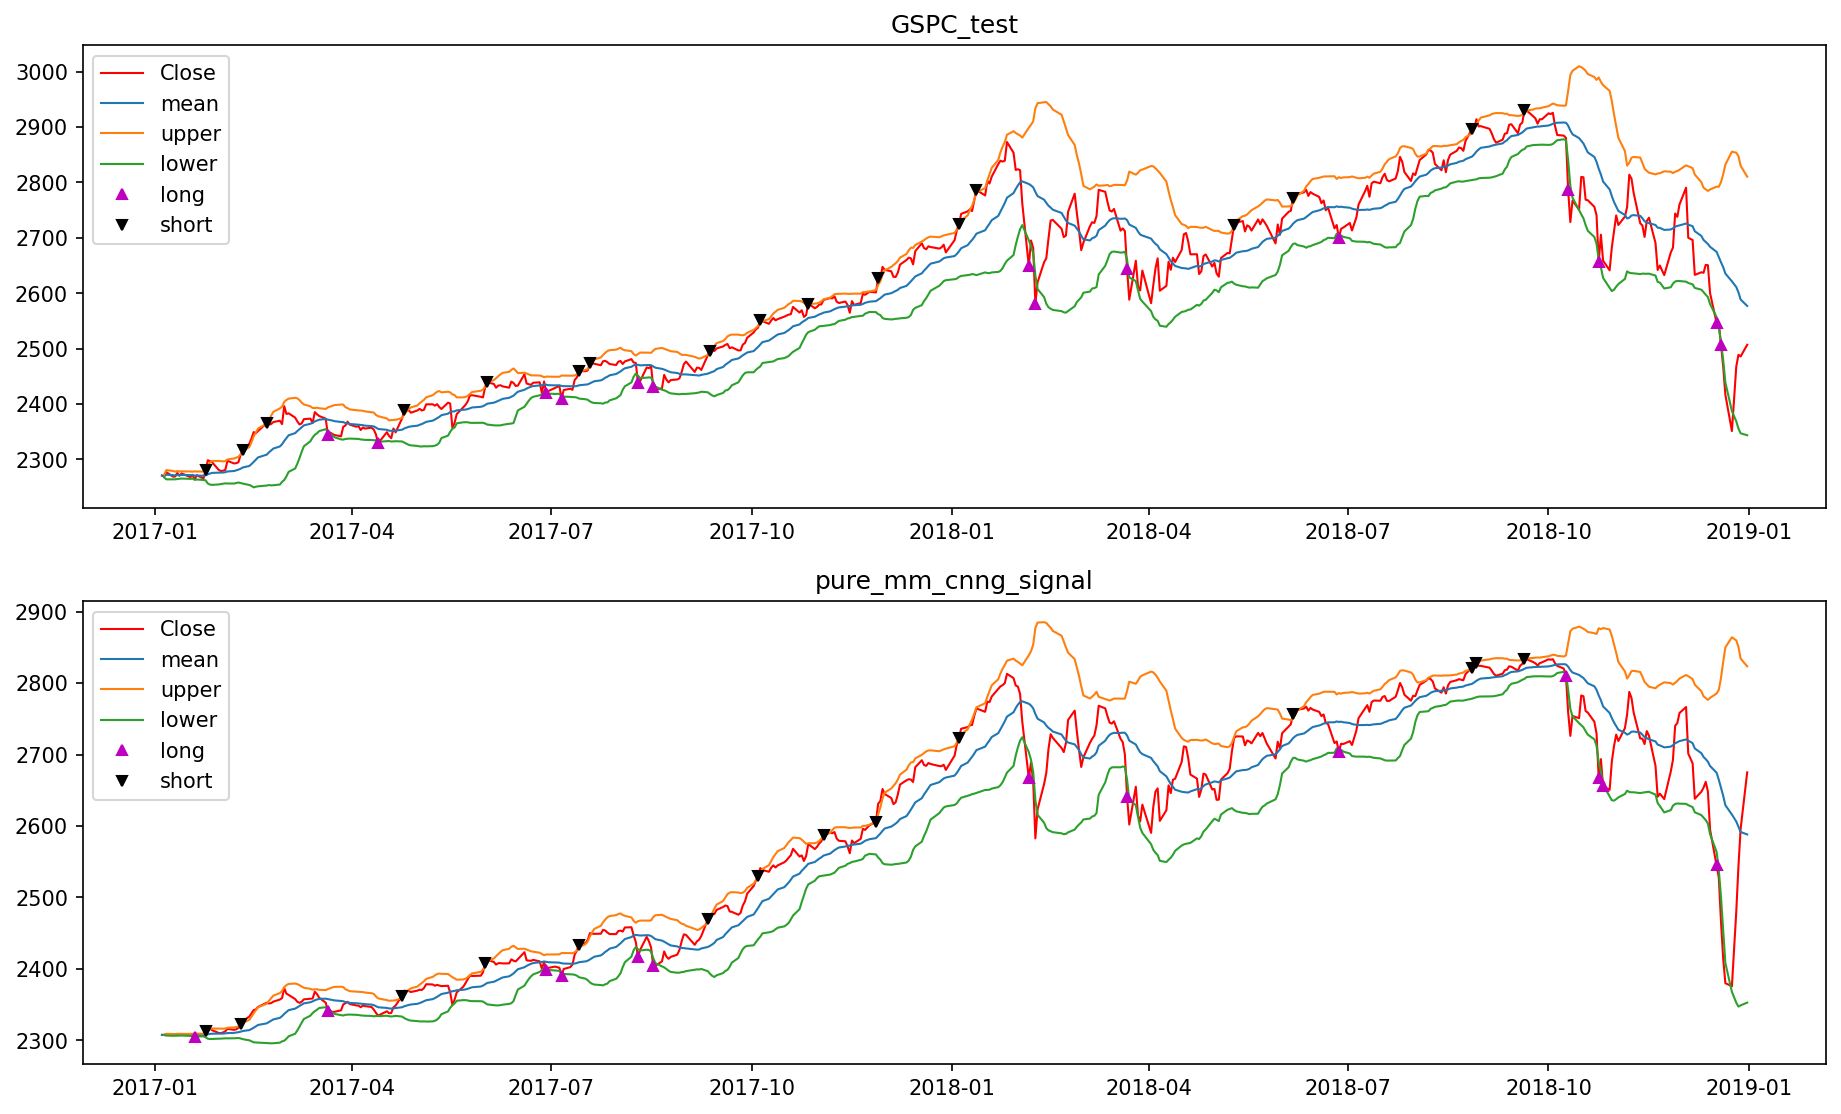

In [329]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnng_signal')
plt.plot(pure_mm_cnng_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnng_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnng_signal.loc[pure_mm_cnng_signal.signal == 1.0].index, 
         pure_mm_cnng_signal.Price[pure_mm_cnng_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnng_signal.loc[pure_mm_cnng_signal.signal == -1.0].index, 
         pure_mm_cnng_signal.Price[pure_mm_cnng_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    

# plt.subplot(3,1,3)
# plt.title('pure_mm_lstm_signal')
# plt.plot(pure_mm_lstm_signal['GSPC_test'], color='r', lw=1,label='Close')
# plt.plot(pure_mm_lstm_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
# plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == 1.0].index, 
#          pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == 1.0],
#          '^', markersize=5, color='m',label='long')
# plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == -1.0].index, 
#          pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == -1.0],
#          'v', markersize=5, color='k',label='short')
# plt.legend()   

## MACD

In [330]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

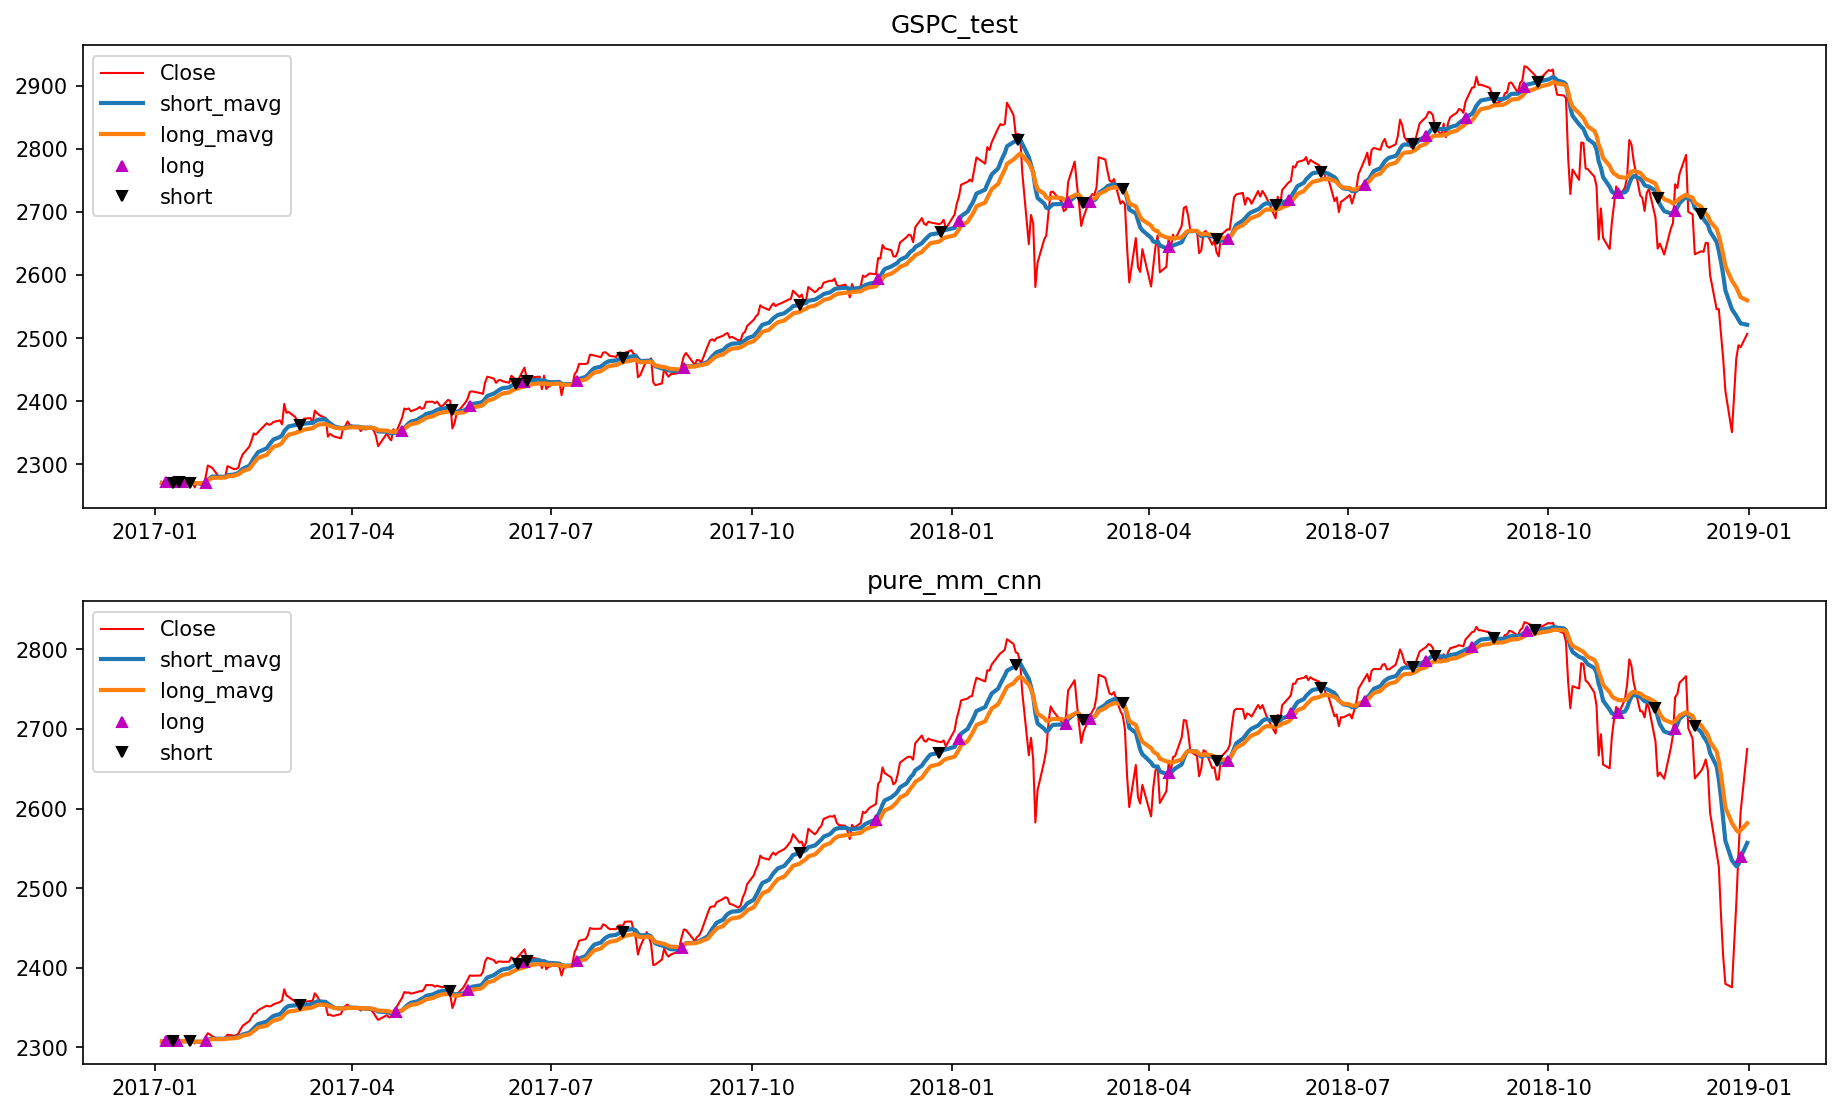

In [331]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnng_macd=MACD(pure_mm_cnng,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnng['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnng_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnng_macd.loc[pure_mm_cnng_macd.positions == 1.0].index, 
         pure_mm_cnng_macd.short_mavg[pure_mm_cnng_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnng_macd.loc[pure_mm_cnng_macd.positions == -1.0].index, 
         pure_mm_cnng_macd.short_mavg[pure_mm_cnng_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   

# plt.subplot(3,1,3)
# plt.title('pure_mm_lstm')
# plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
# plt.plot(pure_mm_lstm_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
# plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == 1.0].index, 
#          pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == 1.0],
#          '^', markersize=5, color='m',label='long')
# plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == -1.0].index, 
#          pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == -1.0],
#          'v', markersize=5, color='k',label='short')
# plt.legend()   

In [332]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnng_macd:\n',pure_mm_cnng_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    456
 1.0     22
-1.0     22
Name: positions, dtype: int64 

pure_mm_cnng_macd:
  0.0    457
 1.0     22
-1.0     21
Name: positions, dtype: int64 



In [333]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnng_macd['positions']==1])

                  Close
Date                   
2017-01-06  2276.979980
2017-01-11  2275.320068
2017-01-13  2274.639893
2017-01-24  2280.070068
2017-04-24  2374.149902
2017-05-25  2415.070068
2017-06-19  2453.459961
2017-07-13  2447.830078
2017-08-31  2471.649902
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-02-23  2747.300049
2018-03-05  2720.939941
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-04  2746.870117
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
                  Close
Date                   
2017-01-06  2276.979980
2017-01-11  2275.320068
2017-01-24  2280.070068
2017-04-21  2348.689941
2017-05-24  2404.389893
2017-06-19  2453.459961
2017-07-13  2447.830078
2017-08-30  2457.590088
2017-11-27  2601.419922
2018-01-04  2723.989990
2018-02-22  2703.959961
2018-03-05  2720.939941
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-05  2748.800049
2018-07-09  2784

In [334]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnng_macd['positions']==-1])

                  Close
Date                   
2017-01-09  2268.899902
2017-01-12  2270.439941
2017-01-17  2267.889893
2017-03-08  2362.979980
2017-05-17  2357.030029
2017-06-15  2432.459961
2017-06-20  2437.030029
2017-08-03  2472.159912
2017-10-23  2564.979980
2017-12-27  2682.620117
2018-01-31  2823.810059
2018-03-02  2691.250000
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
                  Close
Date                   
2017-01-09  2268.899902
2017-01-17  2267.889893
2017-03-08  2362.979980
2017-05-16  2400.669922
2017-06-16  2433.149902
2017-06-20  2437.030029
2017-08-03  2472.159912
2017-10-23  2564.979980
2017-12-26  2680.500000
2018-01-30  2822.429932
2018-03-02  2691.250000
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816

## MA

In [335]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

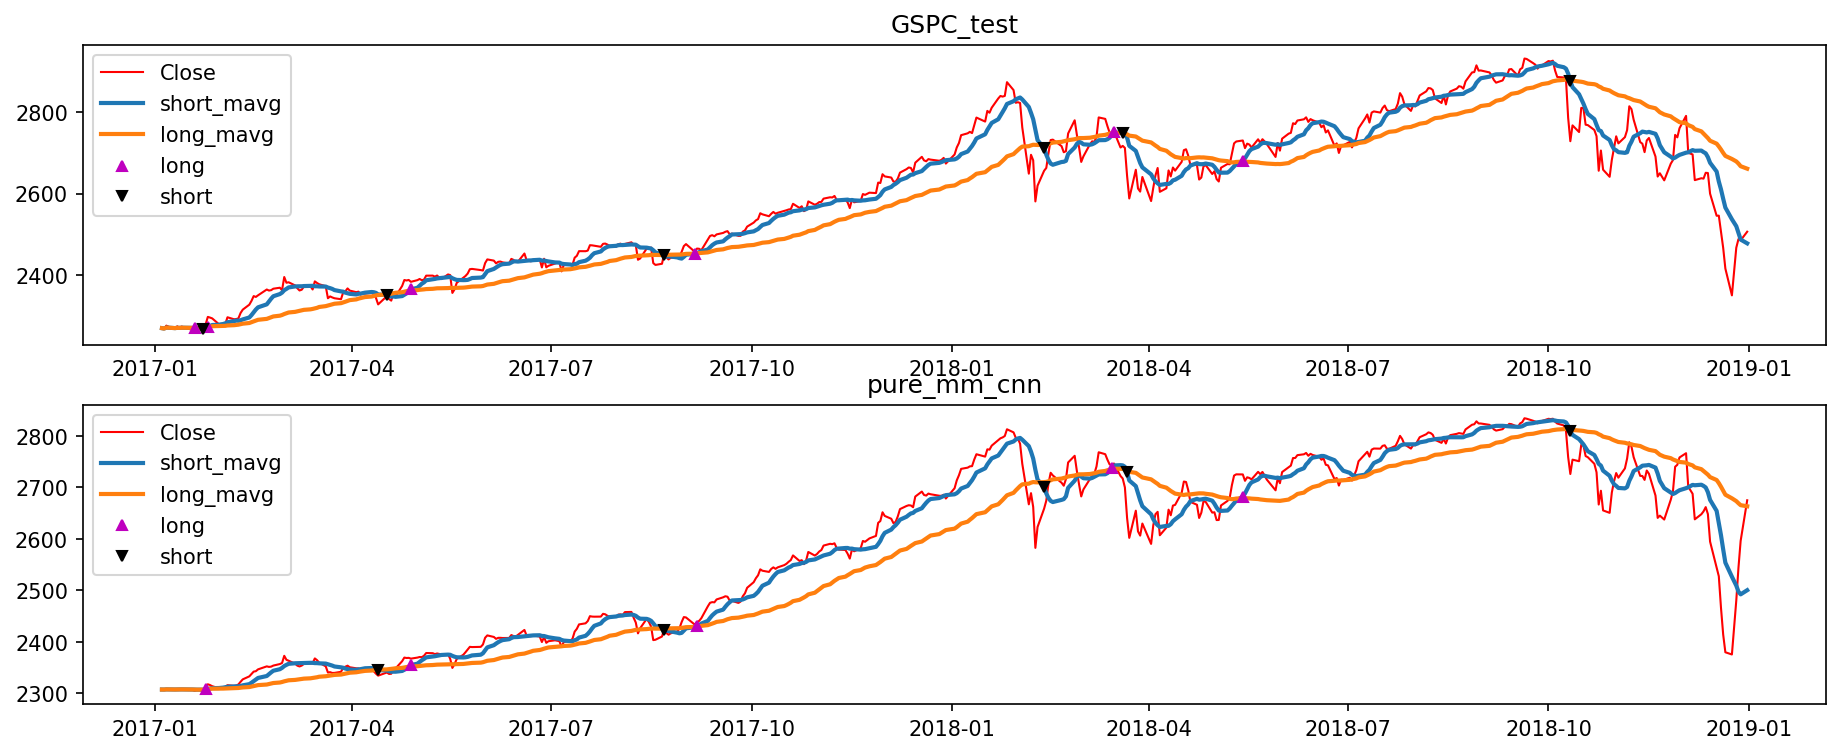

In [336]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnng_ma=MA(pure_mm_cnng,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnng['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnng_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnng_ma.loc[pure_mm_cnng_ma.positions == 1.0].index, 
         pure_mm_cnng_ma.short_mavg[pure_mm_cnng_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnng_ma.loc[pure_mm_cnng_ma.positions == -1.0].index, 
         pure_mm_cnng_ma.short_mavg[pure_mm_cnng_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   

# plt.subplot(3,1,3)
# plt.title('pure_mm_lstm')
# plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
# plt.plot(pure_mm_lstm_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
# plt.plot(pure_mm_lstm_ma.loc[pure_mm_lstm_ma.positions == 1.0].index, 
#          pure_mm_lstm_ma.short_mavg[pure_mm_lstm_ma.positions == 1.0],
#          '^', markersize=5, color='m',label='long')
# plt.plot(pure_mm_lstm_ma.loc[pure_mm_lstm_ma.positions == -1.0].index, 
#          pure_mm_lstm_ma.short_mavg[pure_mm_lstm_ma.positions == -1.0],
#          'v', markersize=5, color='k',label='short')
# plt.legend()   

In [337]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnng_ma:\n',pure_mm_cnng_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    488
 1.0      6
-1.0      6
Name: positions, dtype: int64 

pure_mm_cnng_ma:
  0.0    490
 1.0      5
-1.0      5
Name: positions, dtype: int64 



In [338]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnng_ma['positions']==1])

                  Close
Date                   
2017-01-19  2263.689941
2017-01-25  2298.370117
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-16  2752.010010
2018-05-14  2730.129883
                  Close
Date                   
2017-01-24  2280.070068
2017-04-28  2384.199951
2017-09-06  2465.540039
2018-03-15  2747.330078
2018-05-14  2730.129883


In [339]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnng_ma['positions']==-1])

                  Close
Date                   
2017-01-23  2265.199951
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
                  Close
Date                   
2017-04-13  2328.949951
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-22  2643.689941
2018-10-11  2728.370117


## Strategies backtest

In [340]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Close']=dataset['Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [341]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnng_backtesting=combinesig(GSPC_test,pure_mm_cnng_ma,pure_mm_cnng_macd,pure_mm_cnng_signal)
#pure_mm_lstm_backtesting=combinesig(GSPC_test,pure_mm_lstm_ma,pure_mm_lstm_macd,pure_mm_lstm_signal)

In [342]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Close'][i])*100
            if cash//(100*dataset['Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Close'][i])*100*dataset['Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [343]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnng=backtest(pure_mm_cnng_backtesting,signal='masig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnng)
#print(mareturn_lstm)

0.12136884912109375
0.08848555419921875


In [344]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnng=backtest(pure_mm_cnng_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnng)
#print(mareturn_lstm)

0.03508548461914063
0.12824970556640625


In [345]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnng=backtest(pure_mm_cnng_backtesting,signal='bbsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnng)
#print(mareturn_lstm)

0.05261858813476562
0.03419383715820312


# bit

## Fit models(ltsm/cnn)

## MinMaxScaler(bit)

In [267]:
mm_t_b = MinMaxScaler()
bnoise_mm = mm_t_b.fit_transform(bit_noisy.T).T
bprue_mm=mm_t_b.transform(bit_pure.T).T
print(bprue_mm.shape)
print(bnoise_mm.shape)

(100, 188316)
(100, 188316)


In [268]:
btrain_prue_mm=np.reshape(bprue_mm,(len(bprue_mm), len(bprue_mm[0]), 1))
btrain_mm=np.reshape(bnoise_mm, (len(bnoise_mm), len(bnoise_mm[0]), 1))

# convert list to numpy array
X_train_mmb = np.asarray(btrain_mm)
Y_train_mmb = np.asarray(btrain_prue_mm)
X_train_mmb, X_val_mmb, Y_train_mmb, Y_val_mmb = train_test_split(X_train_mmb, Y_train_mmb, test_size=0.2,random_state=0)

In [283]:
bit_test = pd.read_csv('bit_c_1m.csv')
bit_test['Open Time']=pd.to_datetime(bit_test['Open Time'])
bit_test.set_index('Open Time', inplace=True)
bit_test=bit_test[1:]
bit_test=pd.DataFrame(bit_test['Close'])
bit_test

,Close
Open Time,
2021-01-01 00:01:00,29009.91
2021-01-01 00:02:00,28989.30
2021-01-01 00:03:00,28982.69
2021-01-01 00:04:00,28975.65
2021-01-01 00:05:00,28937.11
...,...
2021-05-12 05:35:00,57485.07
2021-05-12 05:36:00,57481.49
2021-05-12 05:37:00,57470.00


## LSTM

In [13]:
def set_model_LSTM():
    model = Sequential()
    #model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(LSTM(8, input_shape=(None, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    #model.add(AveragePooling1D(2, padding='same'))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    model.add(LSTM(8, activation='tanh',return_sequences = True))
    #model.add(UpSampling1D(2))
    #model.add(Dense(1,activation='tanh'))#
    model.add(Conv1D(1,kernel_size=2,activation='relu', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, None, 4)           208       
                                                                 
 lstm_2 (LSTM)               (None, None, 4)           144       
                                                                 
 lstm_3 (LSTM)               (None, None, 8)           416       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 1)           17        
                                                                 
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [14]:
callback = EarlyStopping(monitor='loss', patience=10)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=800, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/800
3/3 [==============================] - 7s 896ms/step - loss: 0.3136 - mae: 0.4874 - val_loss: 0.3019 - val_mae: 0.4751
Epoch 2/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2920 - mae: 0.4651 - val_loss: 0.2678 - val_mae: 0.4424
Epoch 3/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2563 - mae: 0.4304 - val_loss: 0.2280 - val_mae: 0.4020
Epoch 4/800
3/3 [==============================] - 1s 390ms/step - loss: 0.2154 - mae: 0.3880 - val_loss: 0.1842 - val_mae: 0.3534
Epoch 5/800
3/3 [==============================] - 1s 430ms/step - loss: 0.1713 - mae: 0.3387 - val_loss: 0.1393 - val_mae: 0.3028
Epoch 6/800
3/3 [==============================] - 1s 396ms/step - loss: 0.1272 - mae: 0.2888 - val_loss: 0.0975 - val_mae: 0.2533
Epoch 7/800
3/3 [==============================] - 1s 400ms/step - loss: 0.0875 - mae: 0.2425 - val_loss: 0.0643 - val_mae: 0.2164
Epoch 8/800
3/3 [==============================] - 1s 390ms/step - loss: 0.0581 - m

In [49]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [19]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

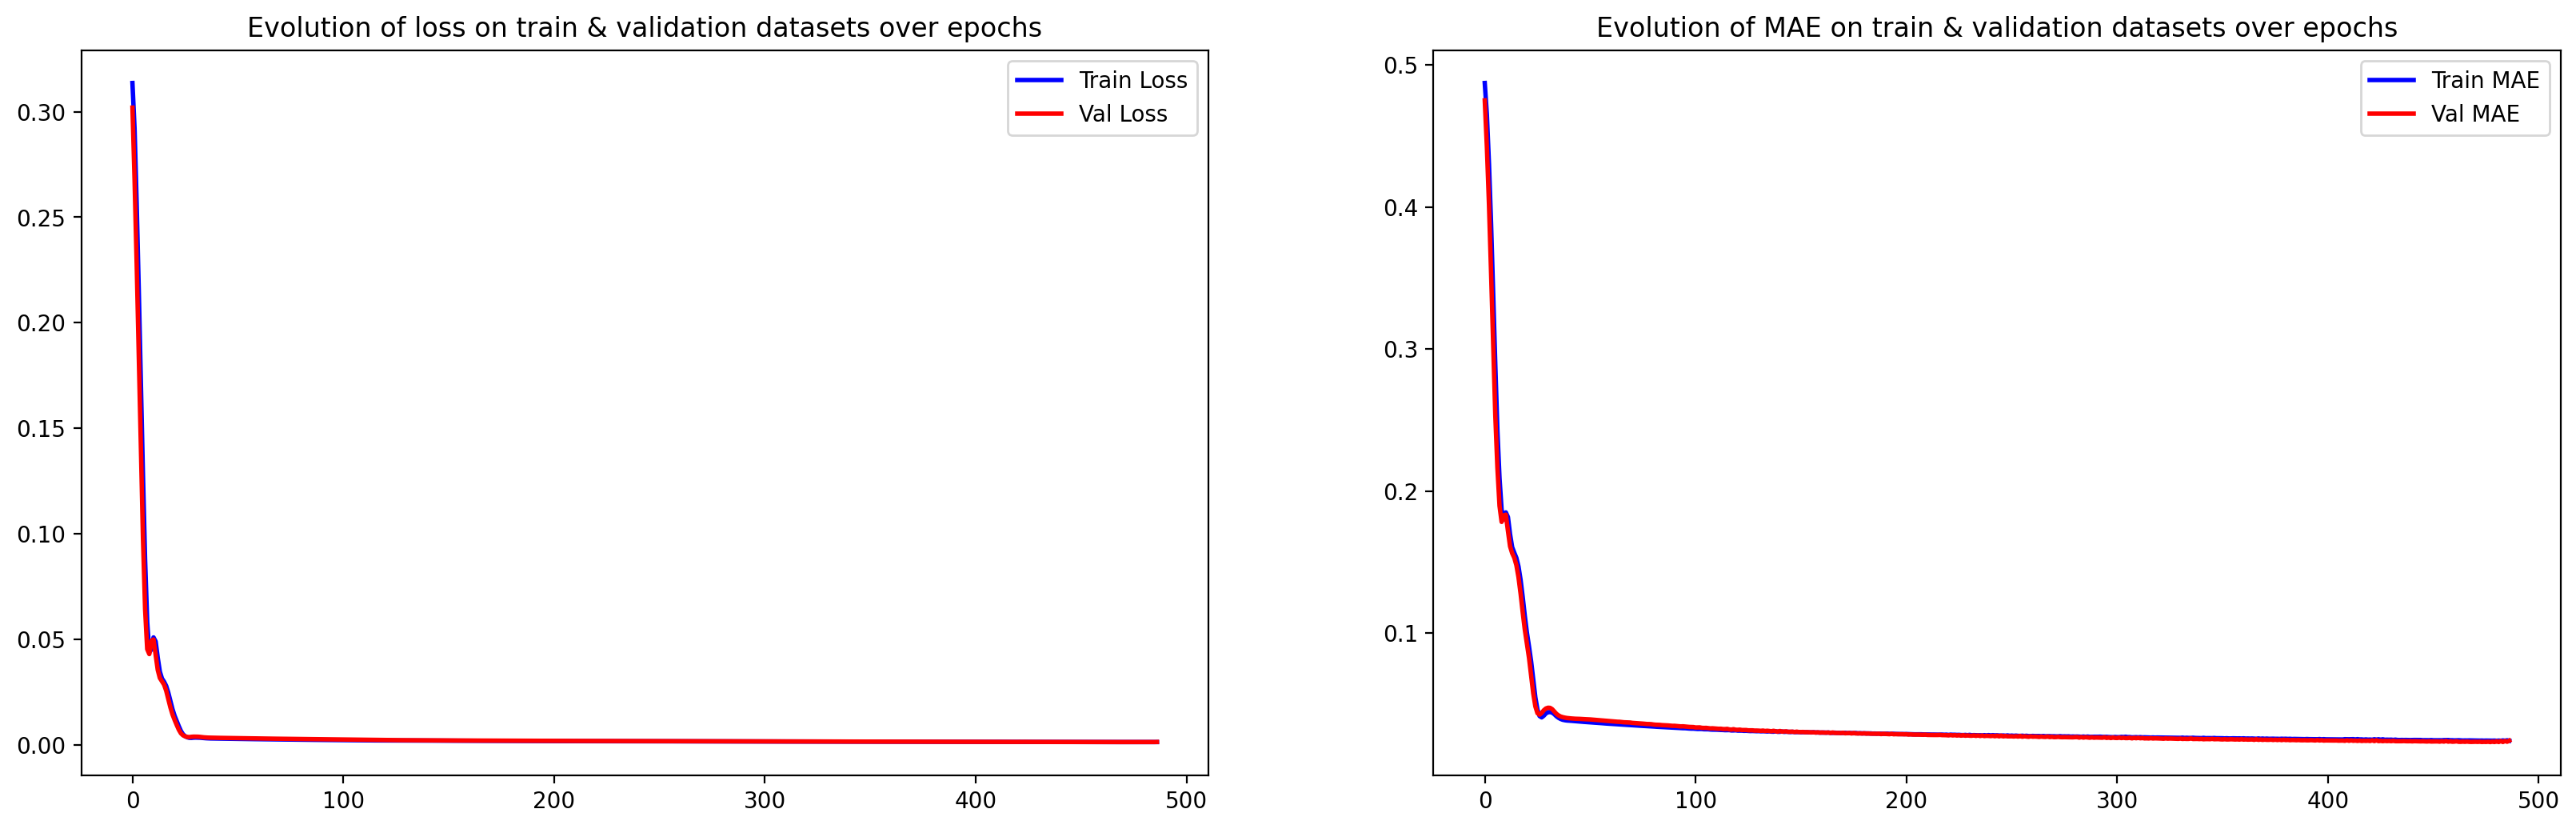

In [15]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mae = history_LSTM.history['mae']
epoch_val_mae = history_LSTM.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 1s 1s/step


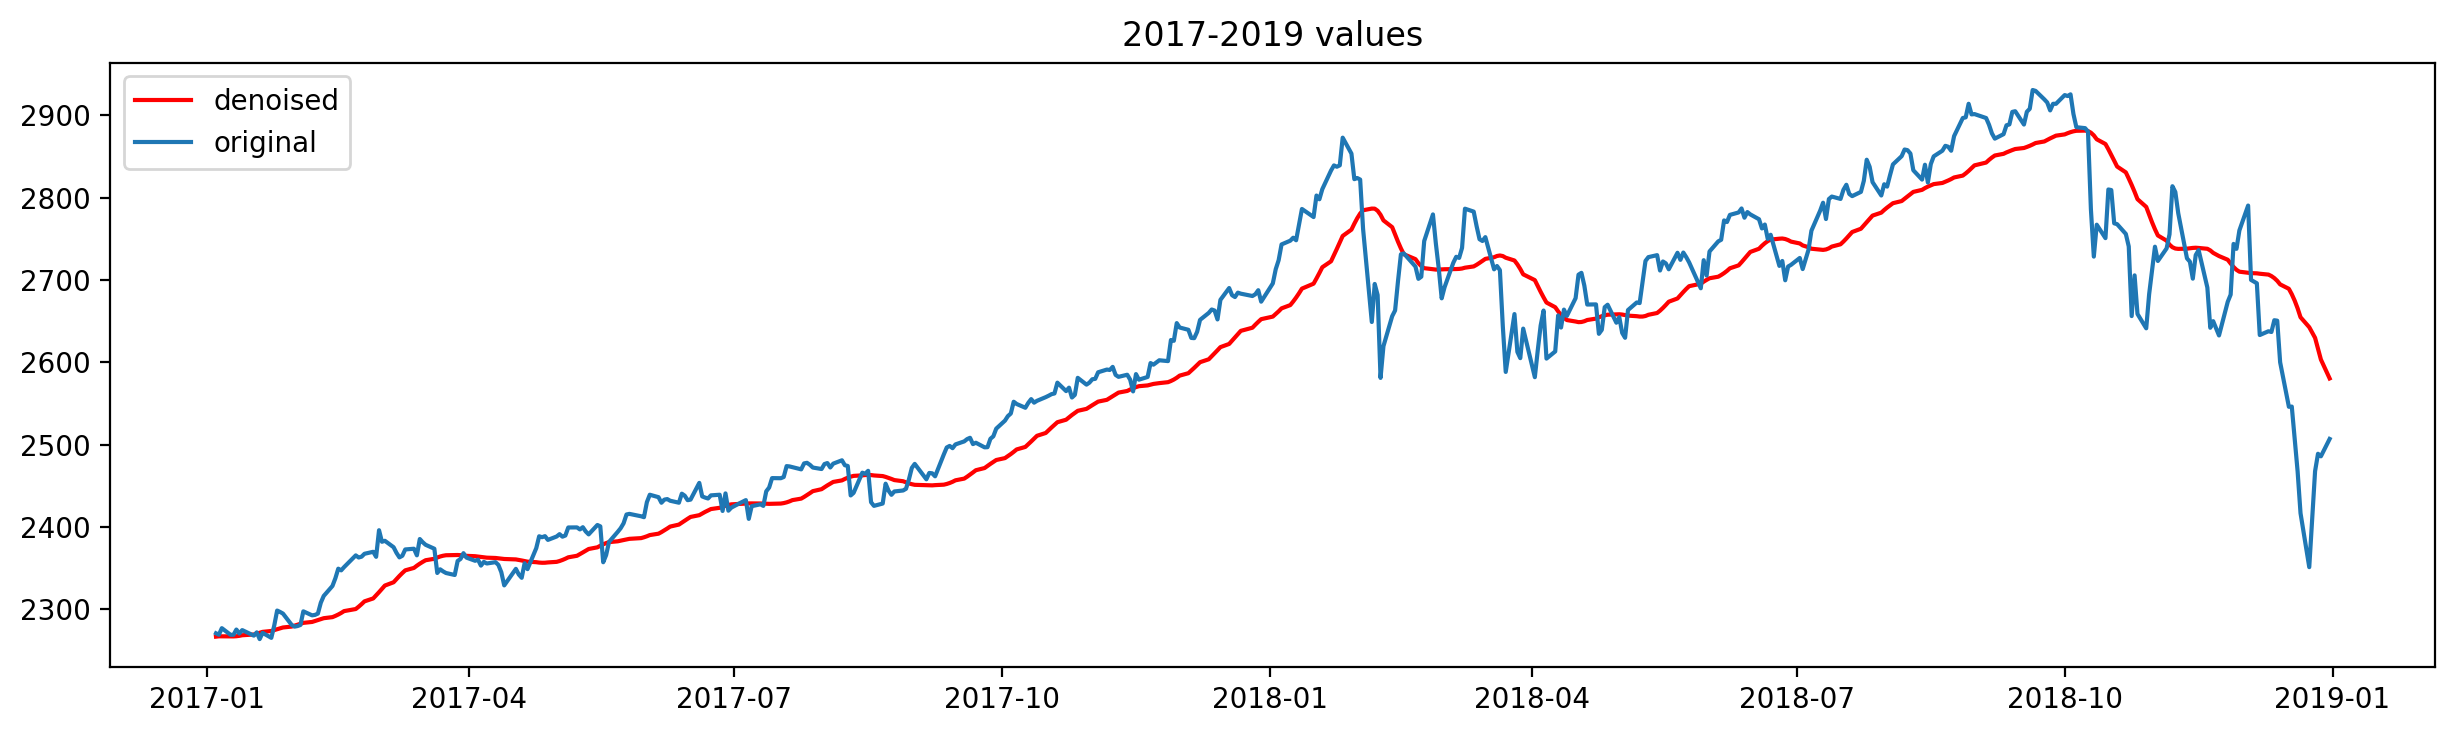

In [16]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=16)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((len(GSPC_test),1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 values')
plt.legend(['denoised', 'original'], loc='upper left')

## CNN

In [270]:
def set_model_encoding_mmb():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=2,activation='tanh',padding='same'))
    model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same'))
    model.add(Conv1D(128, kernel_size=2,activation='tanh',padding='same'))
    model.add(Conv1D(1,kernel_size=2,activation='relu', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mmb = set_model_encoding_mmb()
modelen_mmb.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, None, 128)         384       
                                                                 
 conv1d_71 (Conv1D)          (None, None, 64)          16448     
                                                                 
 conv1d_72 (Conv1D)          (None, None, 64)          8256      
                                                                 
 conv1d_73 (Conv1D)          (None, None, 128)         16512     
                                                                 
 conv1d_74 (Conv1D)          (None, None, 1)           257       
                                                                 
Total params: 41,857
Trainable params: 41,857
Non-trainable params: 0
_________________________________________________________________


In [271]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mmb = modelen_mmb.fit(X_train_mmb, Y_train_mmb, validation_data = (X_val_mmb, Y_val_mmb), epochs=40, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/40
3/3 [==============================] - 45s 12s/step - loss: 0.3888 - mae: 0.5616 - val_loss: 0.1891 - val_mae: 0.3795
Epoch 2/40
3/3 [==============================] - 36s 11s/step - loss: 0.0953 - mae: 0.2428 - val_loss: 0.0766 - val_mae: 0.2722
Epoch 3/40
3/3 [==============================] - 37s 11s/step - loss: 0.0632 - mae: 0.2433 - val_loss: 0.0021 - val_mae: 0.0355
Epoch 4/40
3/3 [==============================] - 41s 12s/step - loss: 0.0134 - mae: 0.0872 - val_loss: 0.0394 - val_mae: 0.1700
Epoch 5/40
3/3 [==============================] - 37s 11s/step - loss: 0.0305 - mae: 0.1471 - val_loss: 0.0033 - val_mae: 0.0520
Epoch 6/40
3/3 [==============================] - 39s 11s/step - loss: 0.0039 - mae: 0.0548 - val_loss: 0.0150 - val_mae: 0.1217
Epoch 7/40
3/3 [==============================] - 36s 11s/step - loss: 0.0136 - mae: 0.1152 - val_loss: 0.0026 - val_mae: 0.0489
Epoch 8/40
3/3 [==============================] - 37s 12s/step - loss: 0.0022 - mae: 0.0410 - val

In [281]:
modelen_mm.save_weights('model_weights_mmb.h5', overwrite=True)  

In [273]:
modelen_mm.load_weights('model_weights_mmb.h5') 

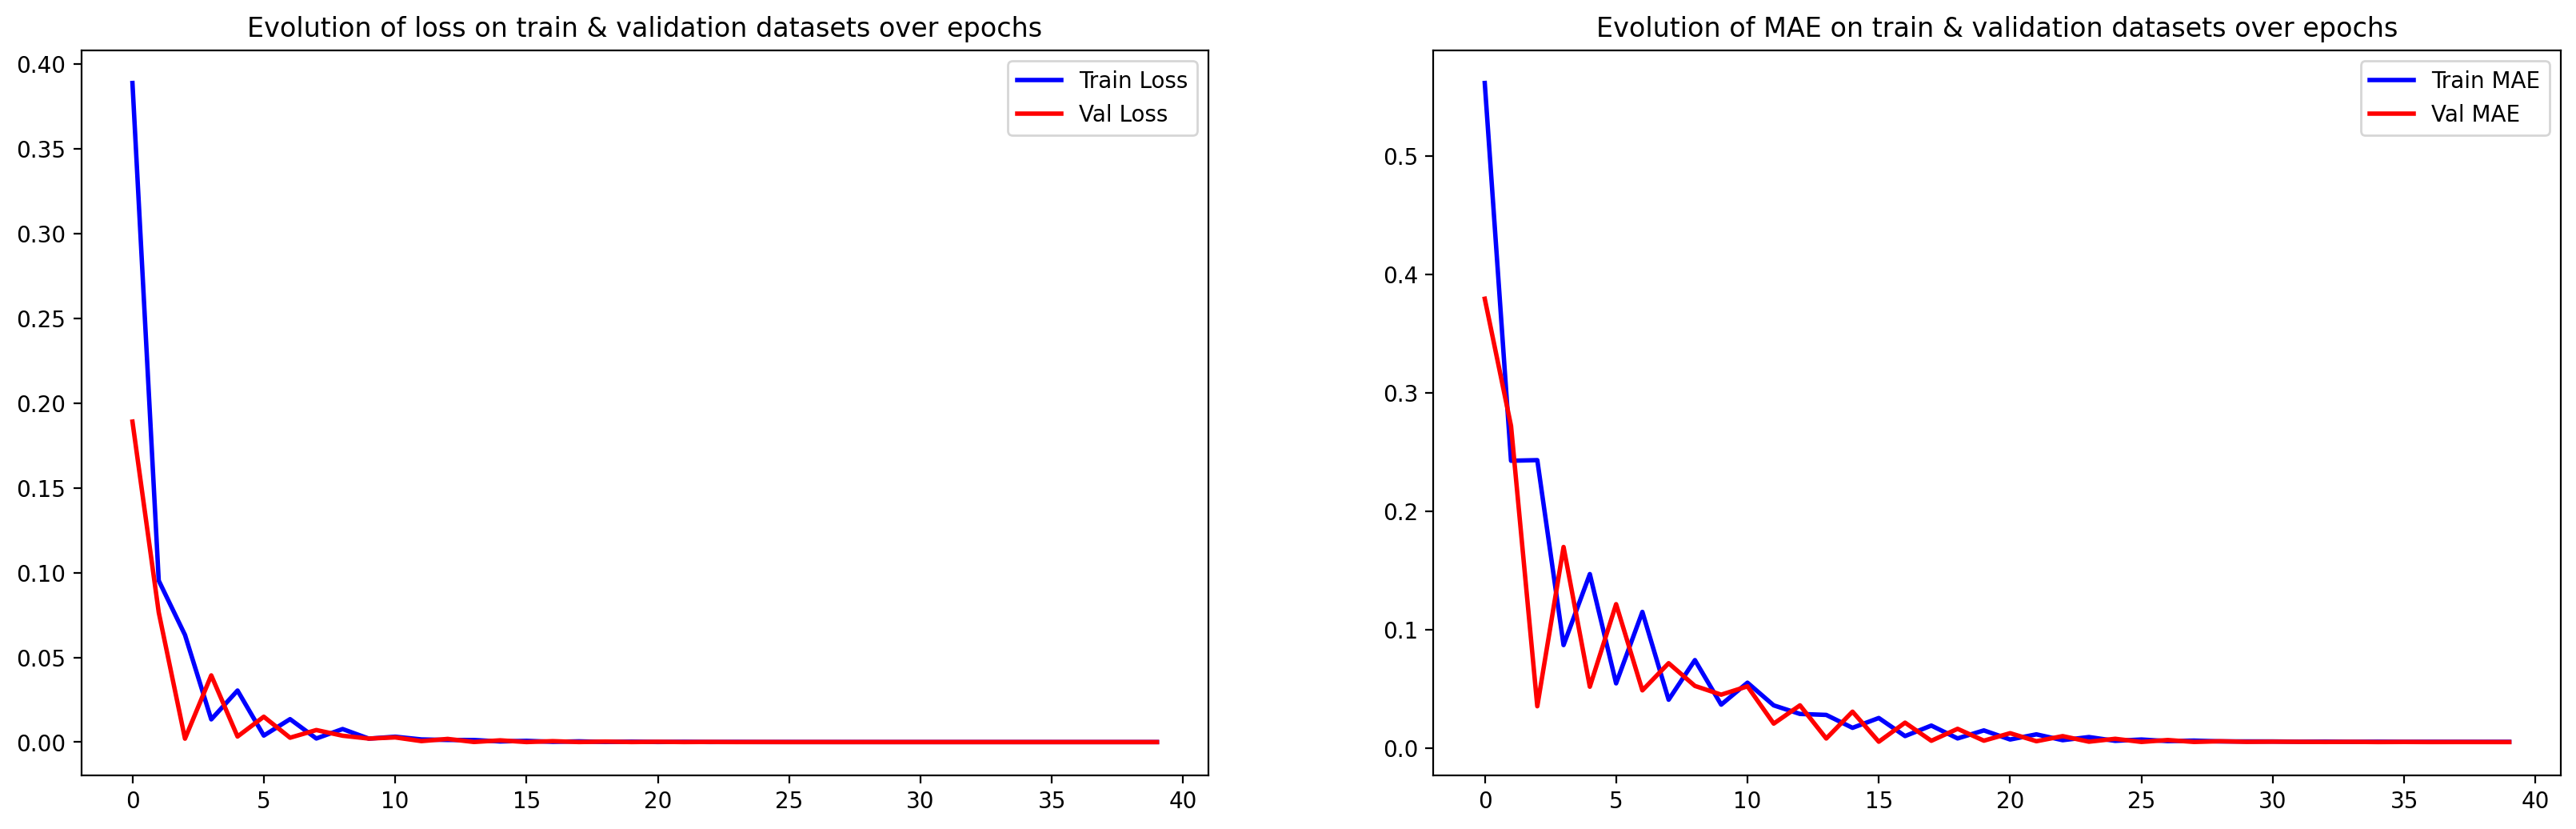

In [274]:
# Check how loss & mae went down
epoch_loss = history_mmb.history['loss']
epoch_val_loss = history_mmb.history['val_loss']
epoch_mae = history_mmb.history['mae']
epoch_val_mae = history_mmb.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 0s 105ms/step


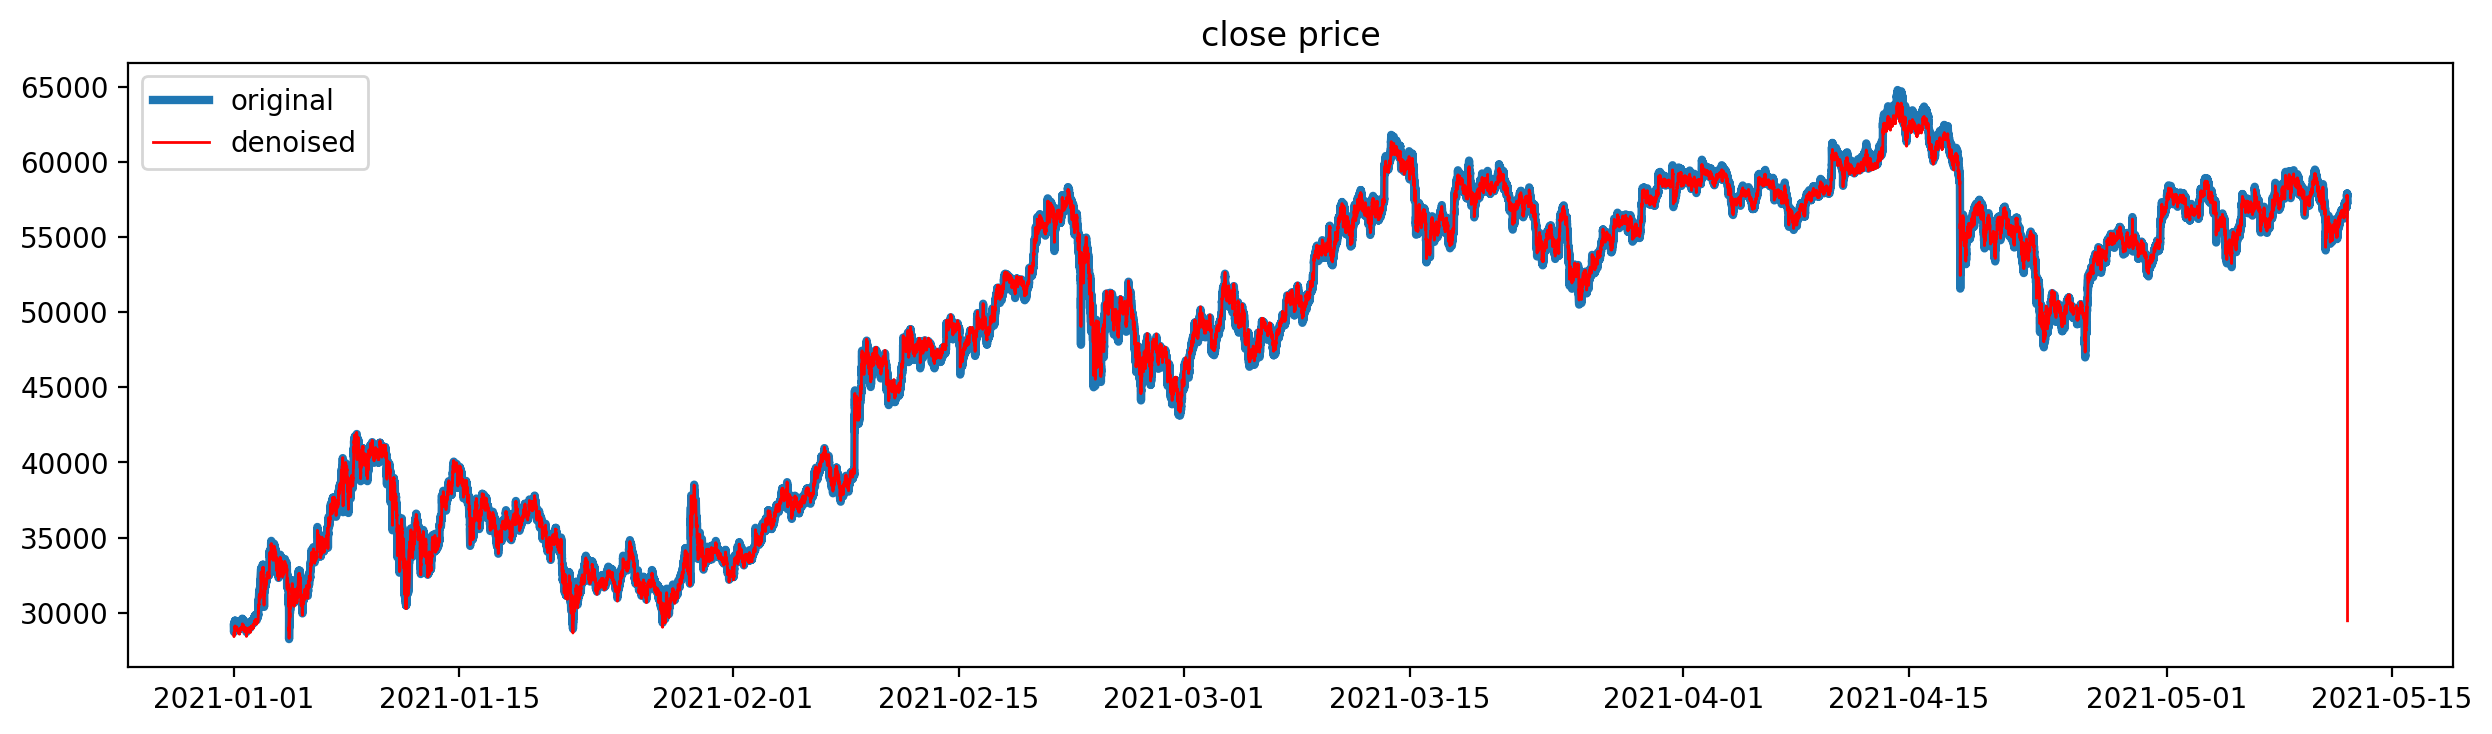

In [292]:
mm_tb = MinMaxScaler()
noise_mm_Tb=mm_tb.fit_transform(bit_test)
Y_test_mm_cnnb = modelen_mmb.predict(noise_mm_Tb.T)
Y_test_mm_cnnb=Y_test_mm_cnnb.reshape((len(bit_test),1))
pure_mm_cnnb = mm_tb.inverse_transform(Y_test_mm_cnnb)
pure_mm_cnnb=pd.DataFrame(pure_mm_cnnb,columns=['Close'],index=bit_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(bit_test,linewidth=3,label='original')
plt.plot(pure_mm_cnnb,'r',linewidth=1,label='denoised')
plt.title('close price')
plt.legend(loc='upper left')

## Models' prediction

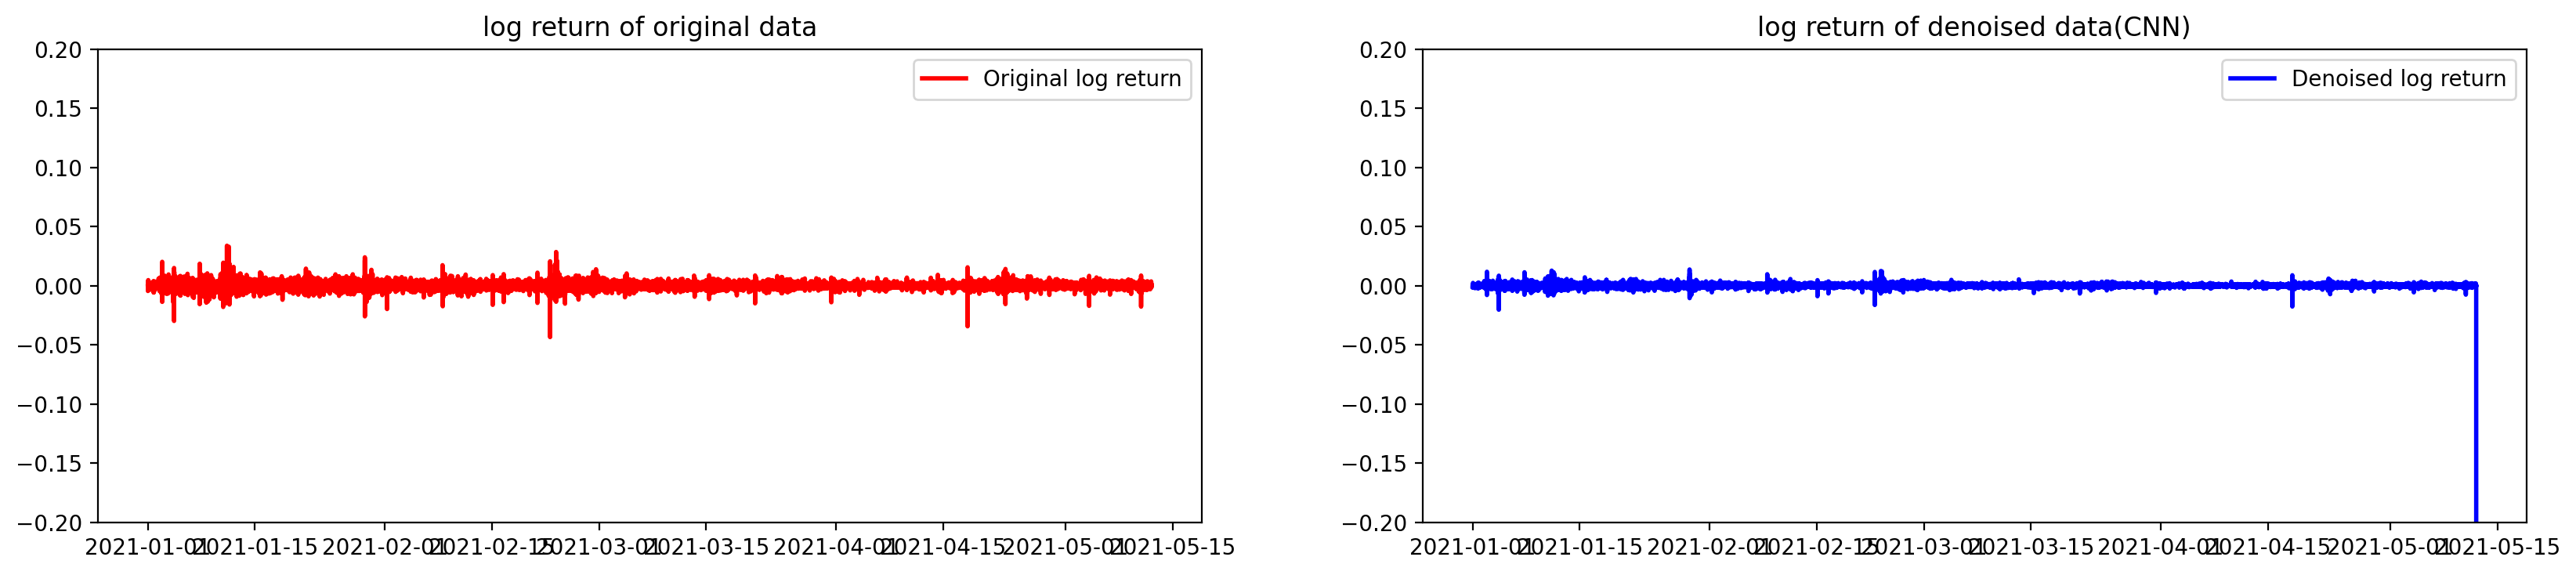

In [293]:
# Log Returns
bit_test_n=bit_test.copy()
bit_test_n['log_ret'] = np.log(bit_test.iloc[:,0]).diff()
#pure_mm_lstm['log_ret'] = np.log(pure_mm_lstm.iloc[:,0]).diff()
pure_mm_cnnb['log_ret'] = np.log(pure_mm_cnnb.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(bit_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnnb['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

# plt.subplot(1,3,3)
# plt.plot(pure_mm_lstm['log_ret'], 'y-', linewidth=2, label='Denoised log return')
# plt.ylim(-0.2,0.2)
# plt.title('log return of denoised data(LSTM)')
# plt.legend(loc='best')

plt.show()

## SVM

In [294]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [295]:
def svmf1(dataset,dataset2,long_predict=10):
    f1=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset['log_ret'].max()
    else:
        max_t=dataset2['log_ret'].max()
    for n in np.arange(0.0, (max_t-0.2*max_t), (max_t-0.2*max_t)/100):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=2,error_score=1).mean())
        
        # for dataset2
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X2=pd.DataFrame()
        Y2=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X2=pd.concat([X2, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y2=pd.concat([Y2, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X2=np.array(X2)
        Y2=np.array(Y2[0])
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f12=np.append(f12,cross_val_score(svc_rbf , X_train2, Y_train2, scoring='f1_micro',cv=2,error_score=1).mean())
    return f1,f12

In [296]:
original_svmb,denoised_svmb=svmf1(bit_test_n,pure_mm_cnnb)

KeyboardInterrupt: 

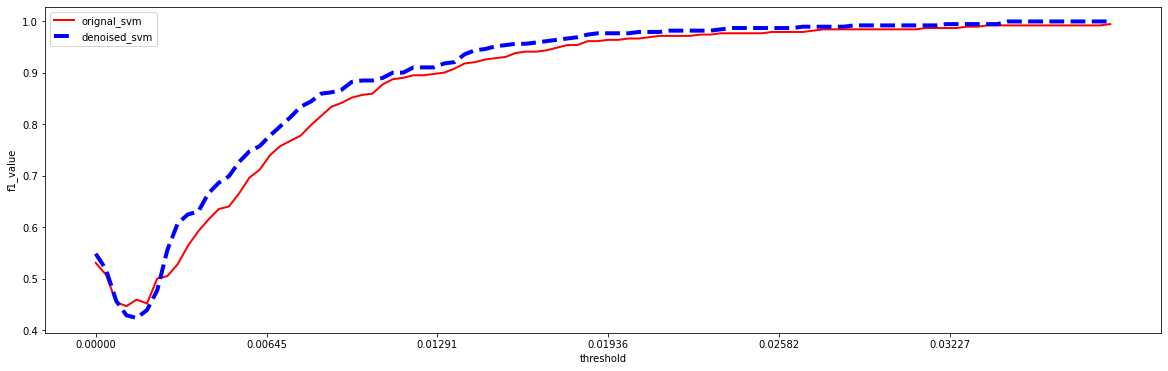

In [131]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0,(max_t-0.2*max_t), (max_t-0.2*max_t)/100),original_svmb,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(max_t-0.2*max_t), (max_t-0.2*max_t)/100),denoised_svmb,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
max_t=0
if bit_test_n['log_ret'].max()>pure_mm_cnnb['log_ret'].max():
    max_t=bit_test_n['log_ret'].max()
else:
    max_t=pure_mm_cnnb['log_ret'].max()
plt.xticks(np.arange(0.0,(max_t-0.2*max_t), (max_t-0.2*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()